# NatalieCNN

Anna Zhu  
2024-10-04

In [ ]:
knitr::opts_chunk$set(echo = TRUE)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


'drc' has been loaded.

Please cite R and 'drc' if used for a publication,
for references type 'citation()' and 'citation('drc')'.


Attaching package: 'drc'

The following objects are masked from 'package:stats':

    gaussian, getInitial

corrplot 0.92 loaded

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following object is masked from 'package:ggpubr':

    mutate

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:purrr':

    compact


Attaching package: 'patchwork'

The following object is masked from 'package:MASS':

    area


Attaching package: 'psych'

The following object is masked from 'package:drc':

    logistic

The following objects are masked from 'package:ggplot2':

    %+%, alpha


Attaching package: 'boot'

The following object is masked from 'package:psych':

    logit

The following object is masked from 'package:robustbase':

    salinity

In [ ]:
theme_minimalism <- function(){

theme_minimal() + # ggplot′s minimal theme hides many unnecessary features of plot
theme( # make modifications to the theme
panel.grid.major.y=element_blank(), # hide major grid for y axis
panel.grid.minor.y=element_blank(), # hide minor grid for y axis
panel.grid.major.x=element_blank(), # hide major grid for x axis
panel.grid.minor.x=element_blank(), # hide minor grid for x axis
text=element_text(size=14), # font aesthetics
axis.text=element_text(size=12),
axis.title=element_text(size=14, face="bold"))

}

# Read Data

In [ ]:
hctdata = read.csv("Hematocrit_Dec21.csv")
hctdata$Date <- yday(dmy(hctdata$Date))
#summary(hctdata)

In [ ]:
rawvalues <- readxl::read_excel("CMRO2calc.xlsx")
rawvalues$Subject <- as.factor(rawvalues$Subject)
rawvalues$Sex <- as.factor(rawvalues$Sex)
rawvalues$DOB <- as.Date(rawvalues$DOB)
rawvalues$DOB <- format(rawvalues$DOB, format = "%d/%m/%Y")
rawvalues$`MRI Scan Date` <- as.Date(rawvalues$`MRI Scan Date`)
rawvalues$`MRI Scan Date` <- format(rawvalues$`MRI Scan Date`, format = "%d/%m/%Y")

In [ ]:
rawvalues$PMA <- rawvalues$`CGA on Scan Day (Week)` + rawvalues$`CGA on Scan Day (Day)`/7
rawvalues$GA <- rawvalues$`GA at birth (week)` + rawvalues$`GA at Birth (day)`/7

# Hct Calculation

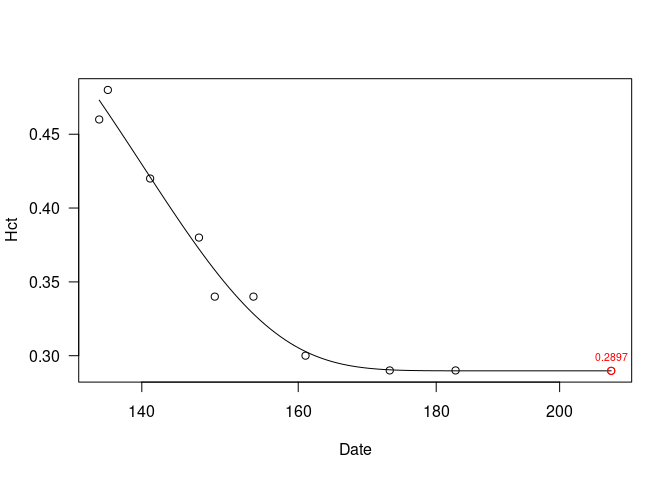

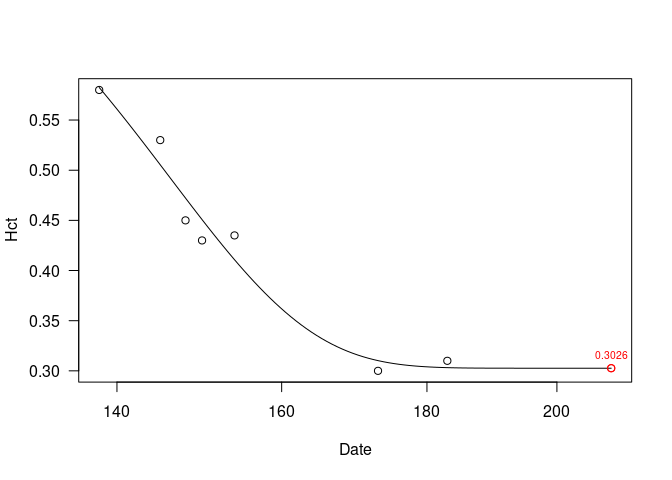

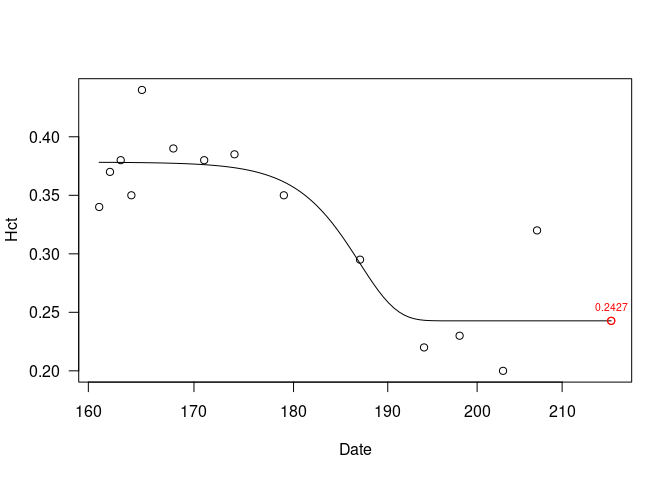

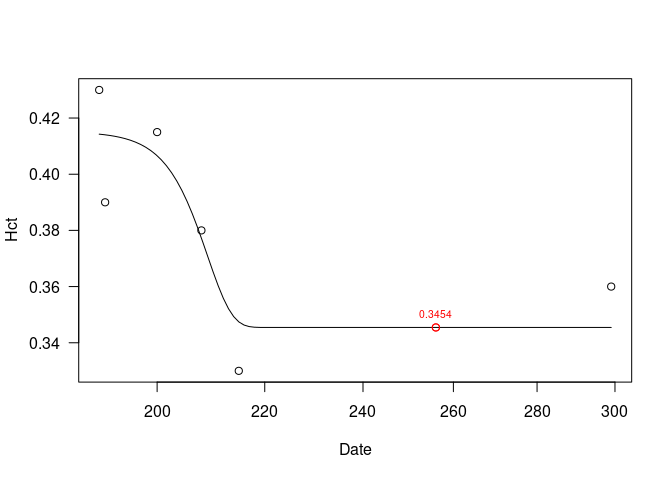

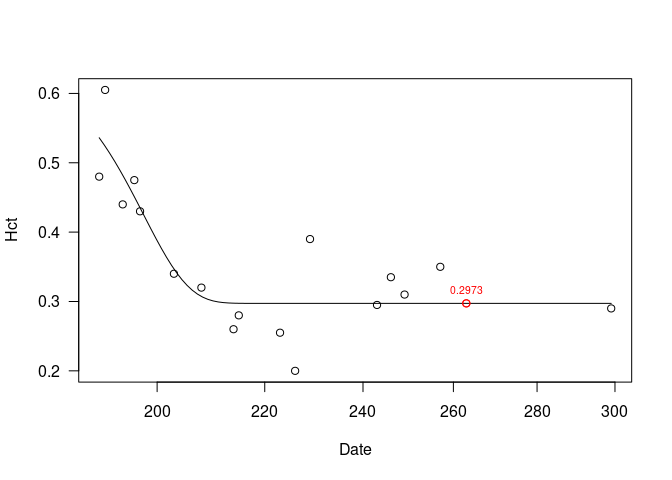

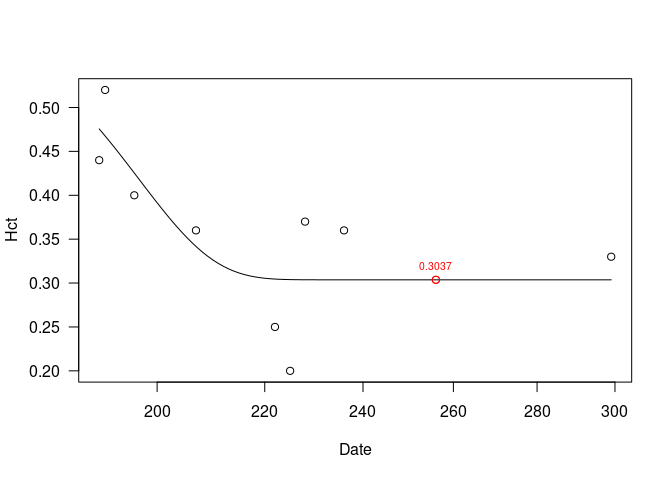

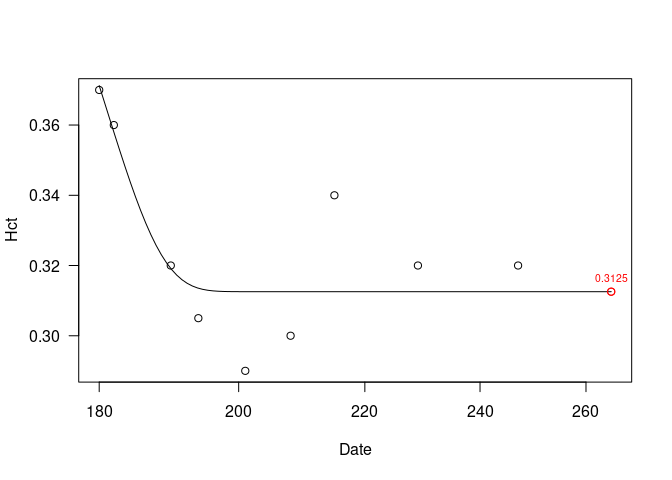

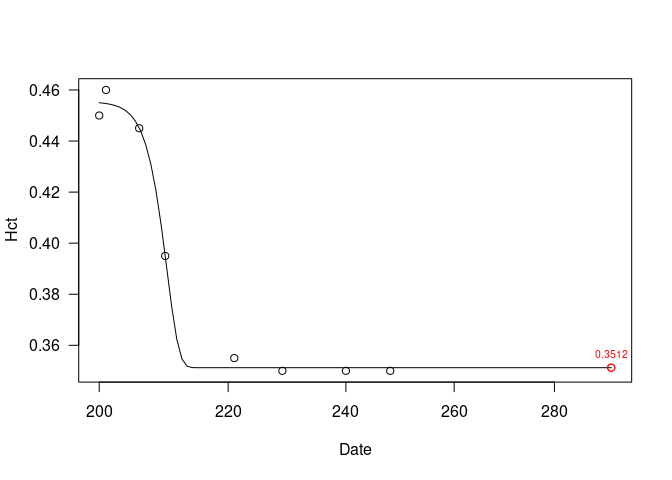

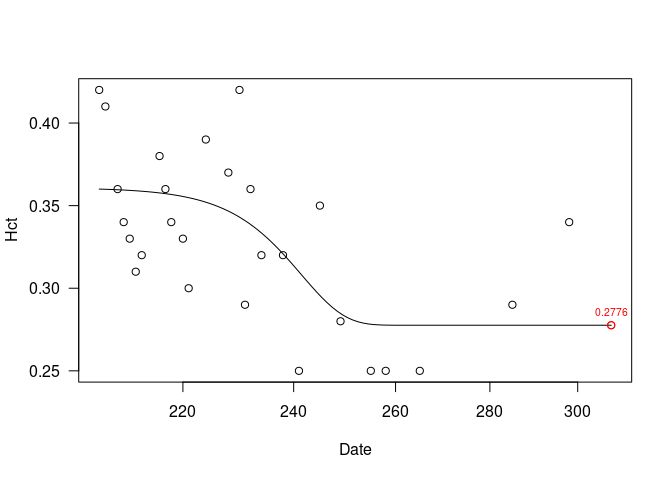

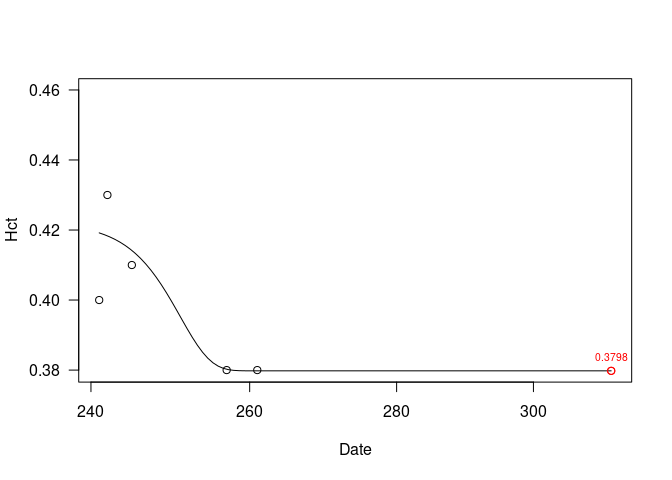

Warning in sqrt(diag(varMat)): NaNs produced

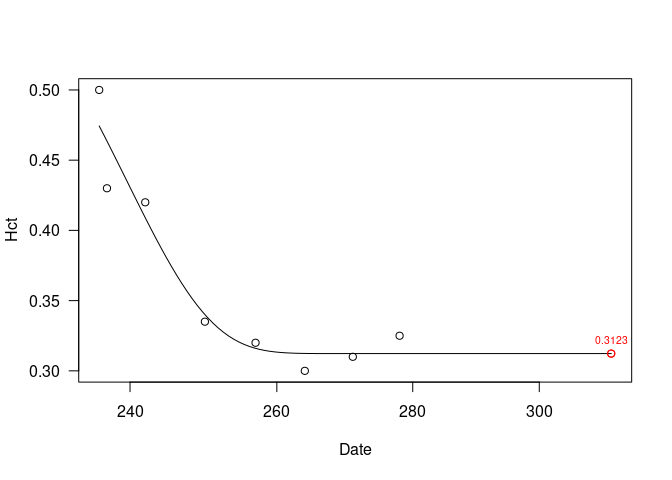

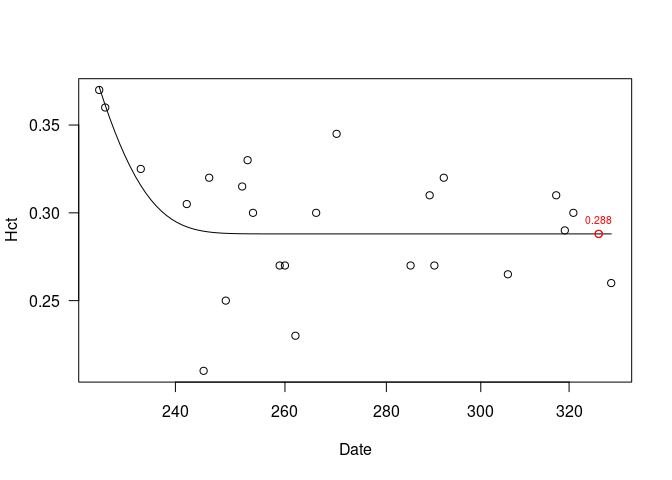

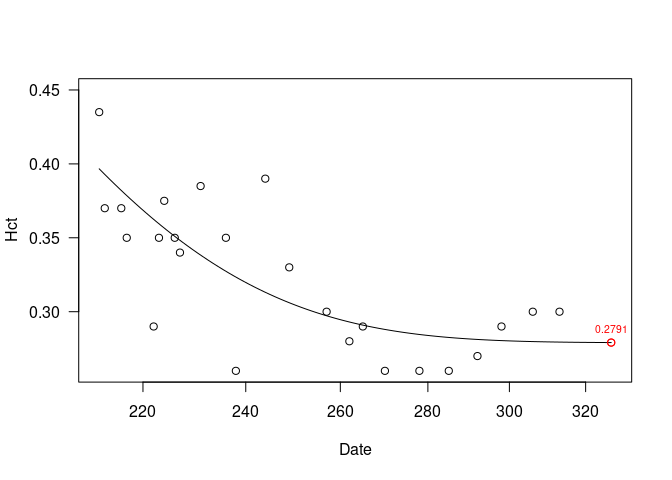

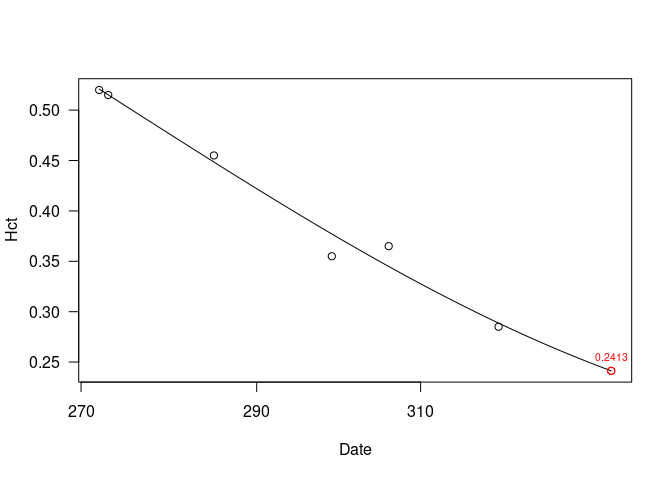

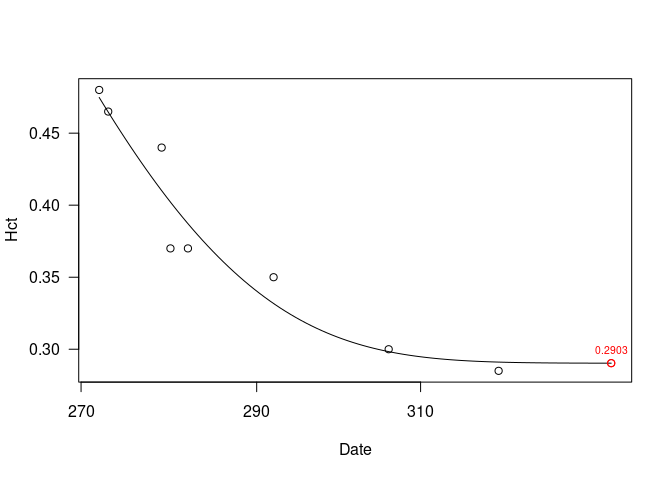

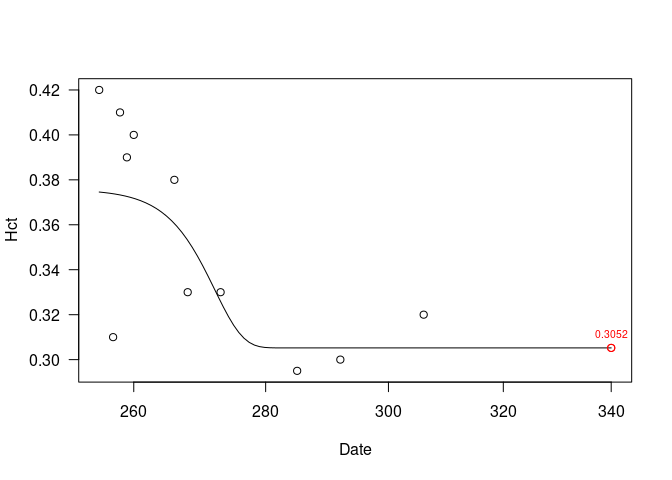

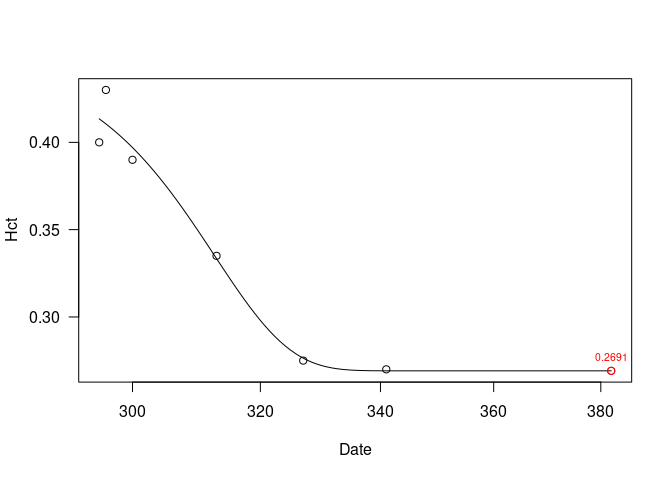

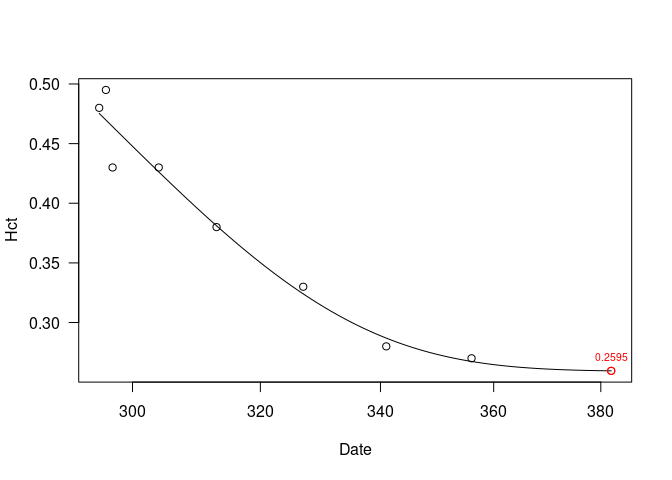

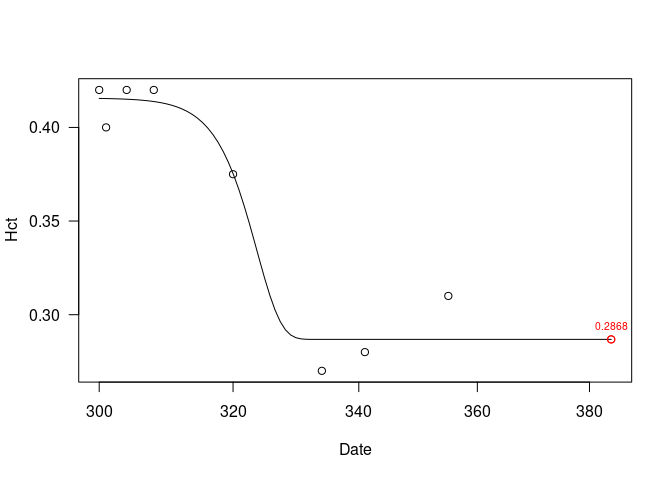

In [ ]:
hctfunc <- function(x,dataframe=newdata) {
  arg_name0 <- deparse(substitute(x))
  arg_name0 <- formatC(x, width = 2, format = "d", flag = "0")
  arg_name <- paste("sub", arg_name0, sep="")
  subjectid <- paste("Sub-AMWCER",arg_name0,sep="")
  y <- paste("Patient", arg_name0, sep=" ")
  x2 <- hctdata %>% filter(ID==y)
  z <- rawvalues %>% filter(Subject == subjectid) %>% pull('MRI Scan Date')
  x2.mridate <- as.numeric(dmy(z) - dmy("01-01-2021"))
  x2.newdata <- data.frame(Date = c(x2.mridate))
  x2.model_W1.4 <- drm(Hct ~ Date, fct=W1.4(), data=x2)
  x2.predict <- predict(x2.model_W1.4, newdata = x2.newdata)
  plot(x2.model_W1.4, xlim=c(min(x2$Date),max(c(x2.newdata$Date,x2$Date))), ylim=c(min(x2$Hct, x2.predict),max(c(x2.predict,x2$Hct)))) + points(x2.newdata$Date,x2.predict, col = "red") + points(x2.newdata$Date,x2.predict, col = "red") + text(x2.newdata$Date,x2.predict,signif(x2.predict,4), cex=0.65, pos=3, col = "red")
  var_name <- paste(arg_name,".pred", sep="")
  x2.predict <- as.data.frame(x2.predict)
  dataframe[dataframe$Subject==subjectid, "Hct"] <- x2.predict
  newdata <<- dataframe
}

newdata <- rawvalues
newdata['Hct'] <- NA
x <- c(1:18,20)
for (val in x) {
  hctfunc(val)
}

In [ ]:
pipelinevalues <- read.csv("pipeline_output_v1.csv")
pipelinevalues <- pipelinevalues %>% dplyr::rename(Subject = Subject_ID)
pipelinevalues <- pipelinevalues %>% dplyr::select(!c(GA, PMA))

newdata$Subject <- gsub('Sub-', '', newdata$Subject)
alldata <- merge(newdata,pipelinevalues,by="Subject")

In [ ]:
#New column with sum of total days invasive and total days noninvasive
alldata$Total_INNI <- alldata$Invasive + alldata$Noninvasive
#New column with sum of total days invasive, total days noninvasive, and total days less invasive
alldata$Total_vent <- alldata$Invasive + alldata$Noninvasive + alldata$Less_Invasive
#New column with sum of total days noninvaisve, and total days less invasive
alldata$Total_NILI <- alldata$Noninvasive + alldata$Less_Invasive
#New column for CSaO2 * 100
alldata$CSaO2_P <- alldata$CSaO2 * 100
#New column for Hct * 100
alldata$Hct_P <- alldata$Hct * 100
#New column with percent of days on invasive
alldata$IN_P <- alldata$Invasive / (alldata$Invasive + alldata$Less_Invasive + alldata$Noninvasive)
#New column with percent of days on noninvasive
alldata$LI_P <- alldata$Noninvasive / (alldata$Invasive + alldata$Less_Invasive + alldata$Noninvasive)
#New column with percent of days on less invasive
alldata$NI_P <- alldata$Less_Invasive / (alldata$Invasive + alldata$Less_Invasive + alldata$Noninvasive)
#New column with proportion of days on ventilation
alldata$Vent_P <- (alldata$Invasive + alldata$Noninvasive + alldata$Less_Invasive) / alldata$NICU
#New column with days on room air
alldata$roomair <- alldata$NICU - (alldata$Invasive + alldata$Noninvasive + alldata$Less_Invasive)

In [ ]:
chiox = -0.03*4*pi
chido = 0.21*4*pi
alldata$Hbt <- alldata$Hct/(3*0.0165)
alldata$chi_veiniminuscsf <- alldata$Avg_Chi_Vein_Segmen_p1thr - alldata$CSF_Chi
alldata$CSvO2 <- 1 - (alldata$chi_veiniminuscsf - (chiox*alldata$Hct))/(chido*alldata$Hct)
alldata$OEF <- (alldata$CSaO2 - alldata$CSvO2)/alldata$CSaO2
alldata$GM_CMRO2 <- alldata$GM_CBF*alldata$OEF*alldata$Hbt
alldata$WM_CMRO2 <- alldata$WM_CBF*alldata$OEF*alldata$Hbt
alldata$Cerebellum_CMRO2 <- alldata$Cerebellum_CBF*alldata$OEF*alldata$Hbt
alldata$Deep_GM_CMRO2 <- alldata$Deep_GM_CBF*alldata$OEF*alldata$Hbt
alldata$Brain_Stem_CMRO2 <- alldata$Brain_Stem_CBF*alldata$OEF*alldata$Hbt
alldata$Hip_and_Amyg_CMRO2 <- alldata$Hip_and_Amyg_CBF*alldata$OEF*alldata$Hbt

In [ ]:
#New column for CSvO2 * 100
alldata$CSvO2_P <- alldata$CSvO2 * 100
#New column for OEF * 100
alldata$OEF_P <- alldata$OEF * 100
alldata[is.na(alldata)] = 0

# Initial Stats

In [ ]:
knitr::kable(allstats <- describe(alldata))

  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                vars    n            mean             sd          median         trimmed            mad             min             max          range         skew     kurtosis             se
  --------------------------- ------ ---- --------------- -------------- --------------- --------------- -------------- --------------- --------------- -------------- ------------ ------------ --------------
  Subject                          1   19    1.000000e+01   5.627314e+00    1.000000e+01    1.000000e+01   7.413000e+00    1.000000e+00    1.900000e+01   1.800000e+01    0.0000000   -1.3904709      1.2909944

  Sex                              2   19    1.526316e+00   5.129892e-01    2.000000e+00    1.529412e+00   0.000000e+00    1.000000e+00    2.000000e+00   1.000000e+00   -0.0971979   -2.0925208      0.1176878

  BW                               3   19    1.276053e+03   2.948707e+02    1.304000e+03    1.279235e+03   3.439632e+02    7.740000e+02    1.724000e+03   9.500000e+02   -0.0230148   -1.2077940     67.6479740

  GA at birth (week)               4   19    2.847368e+01   1.678902e+00    2.800000e+01    2.852941e+01   1.482600e+00    2.500000e+01    3.100000e+01   6.000000e+00   -0.1236631   -0.8086173      0.3851666

  GA at Birth (day)                5   19    2.263158e+00   2.104020e+00    2.000000e+00    2.176471e+00   2.965200e+00    0.000000e+00    6.000000e+00   6.000000e+00    0.5184178   -0.9717412      0.4826953

  DOB                              6   19    6.789474e+00   4.184348e+00    7.000000e+00    6.705882e+00   4.447800e+00    1.000000e+00    1.400000e+01   1.300000e+01    0.0928341   -1.3406587      0.9599554

  MRI Scan Date                    7   19    7.105263e+00   3.970653e+00    7.000000e+00    7.117647e+00   4.447800e+00    1.000000e+00    1.300000e+01   1.200000e+01    0.0221619   -1.3581767      0.9109302

  CGA on Scan Day (Week)           8   19    4.000000e+01   1.414214e+00    4.000000e+01    3.994118e+01   1.482600e+00    3.700000e+01    4.400000e+01   7.000000e+00    0.6698906    1.5789474      0.3244428

  CGA on Scan Day (Day)            9   19    2.526316e+00   1.611363e+00    3.000000e+00    2.529412e+00   1.482600e+00    0.000000e+00    5.000000e+00   5.000000e+00   -0.1580636   -1.2253915      0.3696721

  Weight on Scan Day (kg)         10   19    3.396579e+00   5.977157e-01    3.330000e+00    3.408235e+00   6.745830e-01    2.290000e+00    4.305000e+00   2.015000e+00   -0.1343141   -1.2438874      0.1371254

  Length on Scan Day (cm)         11   19    4.922368e+01   2.930793e+00    5.000000e+01    4.939706e+01   2.223900e+00    4.250000e+01    5.300000e+01   1.050000e+01   -0.9032065   -0.0493731      0.6723700

  Head Cir. on Scan Day (cm)      12   19    3.513158e+01   1.323842e+00    3.550000e+01    3.511765e+01   1.482600e+00    3.300000e+01    3.750000e+01   4.500000e+00   -0.1714567   -1.2872346      0.3037103

  CSaO2                           13   19    9.827895e-01   1.537160e-02    9.890000e-01    9.845882e-01   1.186080e-02    9.360000e-01    9.990000e-01   6.300000e-02   -1.4032691    1.8760110      0.0035265

  PMA                             14   19    4.036090e+01   1.404858e+00    4.057143e+01    4.031933e+01   1.270800e+00    3.742857e+01    4.400000e+01   6.571429e+00    0.4184248    0.5962444      0.3222964

  GA                              15   19    2.879699e+01   1.675701e+00    2.885714e+01    2.889076e+01   2.118000e+00    2.500000e+01    3.100000e+01   6.000000e+00   -0.5063238   -0.6399187      0.3844321

  Hct                             16   19    2.965435e-01   3.493560e-02    2.903233e-01    2.948980e-01   2.206850e-02    2.412795e-01    3.797808e-01   1.385013e-01    0.5630232   -0.0599734      0.0080148

  CSF_Volume                      17   19    1.024565e+05   1.690180e+04    9.876265e+04    1.016667e+05   1.782804e+04    8.029043e+04    1.380505e+05   5.776009e+04    0.5803560   -0.8806700   3877.5397957

  GM_Volume                       18   19    1.406289e+05   2.083372e+04    1.410776e+05    1.406767e+05   2.208167e+04    9.845987e+04    1.819856e+05   8.352571e+04   -0.0406308   -0.5357694   4779.5822419

  WM_Volume                       19   19    1.582211e+05   1.433010e+04    1.576880e+05    1.585026e+05   1.440434e+04    1.275475e+05    1.841099e+05   5.656241e+04   -0.1810337   -0.7242151   3287.5497194

  Bg_Volume                       20   19    1.544704e+05   2.187562e+04    1.515221e+05    1.531829e+05   1.222960e+04    1.263685e+05    2.044604e+05   7.809183e+04    0.7999608   -0.1350893   5018.6123919

  Ventricle_Volume                21   19    7.974358e+03   2.572231e+03    7.446632e+03    7.624511e+03   1.470662e+03    5.773444e+03    1.612267e+04   1.034922e+04    1.9287633    3.1667780    590.1103152

  Cerebellum_Volume               22   19    2.504058e+04   3.943031e+03    2.441780e+04    2.489130e+04   3.885263e+03    1.724647e+04    3.537257e+04   1.812610e+04    0.5536431    0.5817544    904.5933728

  Deep_GM_Volume                  23   19    2.689108e+04   2.763229e+03    2.631196e+04    2.689698e+04   2.708736e+03    2.170566e+04    3.197614e+04   1.027048e+04    0.1403784   -1.0113430    633.9281144

  Brain_Stem_Volume               24   19    5.902329e+03   4.529662e+02    5.780770e+03    5.879107e+03   3.294282e+02    5.189874e+03    7.009564e+03   1.819691e+03    0.7499498   -0.1176460    103.9175671

  Hip_and_Amyg_Volume             25   19    2.537384e+03   2.274147e+02    2.493605e+03    2.533629e+03   2.841771e+02    2.163973e+03    2.974624e+03   8.106506e+02    0.1719723   -0.8866616     52.1725112

  CSF_Chi                         26   19    5.088800e-03   1.276400e-03    5.343000e-03    5.135100e-03   1.666400e-03    2.504000e-03    6.887000e-03   4.383000e-03   -0.2368056   -1.1189033      0.0002928

  GM_Chi                          27   19   -2.872800e-03   6.320000e-04   -2.778000e-03   -2.885800e-03   5.723000e-04   -3.920000e-03   -1.604000e-03   2.316000e-03    0.2265719   -0.8387504      0.0001450

  WM_Chi                          28   19   -7.397000e-04   7.034000e-04   -6.630000e-04   -6.928000e-04   8.584000e-04   -2.503000e-03    2.250000e-04   2.728000e-03   -0.6792824   -0.2316505      0.0001614

  BG_Chi                          29   19    6.034500e-03   9.791600e-03    4.267000e-03    5.844200e-03   9.270700e-03   -8.214000e-03    2.351800e-02   3.173200e-02    0.4256495   -1.2146710      0.0022464

  Ventricle_Chi                   30   19    1.179410e-02   4.332200e-03    1.147400e-02    1.162570e-02   5.393700e-03    6.080000e-03    2.037000e-02   1.429000e-02    0.3862581   -1.1825447      0.0009939

  Cerebellum_Chi                  31   19   -2.535600e-03   1.706900e-03   -2.399000e-03   -2.505000e-03   1.117900e-03   -6.259000e-03    6.680000e-04   6.927000e-03   -0.0717802   -0.3106321      0.0003916

  Deep_GM_Chi                     32   19   -7.642400e-03   1.685600e-03   -7.206000e-03   -7.527100e-03   1.286900e-03   -1.207600e-02   -5.169000e-03   6.907000e-03   -0.9370980    0.4339365      0.0003867

  Brain_Stem_Chi                  33   19   -7.911900e-03   3.580900e-03   -8.667000e-03   -7.941800e-03   3.266200e-03   -1.441300e-02   -9.030000e-04   1.351000e-02    0.4514329   -0.5894009      0.0008215

  Hip_and_Amyg_Chi                34   19    2.117800e-03   5.399000e-03    2.843000e-03    2.782800e-03   3.295800e-03   -1.708600e-02    1.001700e-02   2.710300e-02   -2.1457929    5.7492150      0.0012386

  Avg_Chi_Vein_p15thr             35   19    2.271406e-01   2.452720e-02    2.262390e-01    2.272608e-01   1.900690e-02    1.818270e-01    2.704110e-01   8.858400e-02   -0.0839482   -0.8122127      0.0056269

  Avg_Chi_Vein_Segmen_p1thr       36   19    1.733378e-01   2.282030e-02    1.727670e-01    1.727234e-01   1.728420e-02    1.362880e-01    2.208330e-01   8.454500e-02    0.1854517   -0.7249725      0.0052353

  CSF_CBF                         37   19    1.200480e+01   3.156527e+00    1.239949e+01    1.204934e+01   3.023736e+00    5.743607e+00    1.750877e+01   1.176516e+01   -0.0816599   -0.7344930      0.7241570

  GM_CBF                          38   19    1.430068e+01   4.248092e+00    1.540905e+01    1.444368e+01   4.707252e+00    5.373244e+00    2.079716e+01   1.542392e+01   -0.3225231   -0.8148209      0.9745790

  WM_CBF                          39   19    1.118311e+01   3.110537e+00    1.133164e+01    1.129104e+01   3.378537e+00    4.944177e+00    1.558721e+01   1.064303e+01   -0.3823694   -1.0942990      0.7136063

  BG_CBF                          40   19    1.408752e+01   2.310920e+00    1.472643e+01    1.414138e+01   1.960777e+00    9.152971e+00    1.810630e+01   8.953331e+00   -0.4085498   -0.5702957      0.5301615

  Ventricle_CBF                   41   19    1.009971e+01   3.069492e+00    9.584531e+00    1.016550e+01   3.353084e+00    4.649106e+00    1.443201e+01   9.782899e+00   -0.1724825   -1.2701754      0.7041898

  Cerebellum_CBF                  42   19    2.177752e+01   8.273928e+00    2.214367e+01    2.185477e+01   9.210684e+00    7.297718e+00    3.494411e+01   2.764639e+01    0.0697087   -1.0787500      1.8981692

  Deep_GM_CBF                     43   19    1.810092e+01   6.632392e+00    1.730980e+01    1.805073e+01   6.612396e+00    5.955298e+00    3.109979e+01   2.514449e+01    0.2081908   -0.8123814      1.5215751

  Brain_Stem_CBF                  44   19    2.715718e+01   1.105268e+01    2.696516e+01    2.726638e+01   1.006341e+01    7.143075e+00    4.531499e+01   3.817191e+01    0.1090950   -0.9355707      2.5356583

  Hip_and_Amyg_CBF                45   19    1.998453e+01   6.847789e+00    2.042521e+01    2.006934e+01   7.722819e+00    7.166507e+00    3.136067e+01   2.419417e+01   -0.0358662   -0.8563460      1.5709906

  Invasive                        46   19    4.947368e+00   8.072406e+00    2.000000e+00    3.705882e+00   2.965200e+00    0.000000e+00    3.100000e+01   3.100000e+01    1.9514868    3.1464048      1.8519370

  Noninvasive                     47   19    2.415789e+01   1.590689e+01    1.900000e+01    2.335294e+01   1.186080e+01    6.000000e+00    5.600000e+01   5.000000e+01    0.8014502   -0.7232836      3.6492915

  Less_Invasive                   48   19    9.421053e+00   8.146682e+00    7.000000e+00    9.058824e+00   5.930400e+00    0.000000e+00    2.500000e+01   2.500000e+01    0.7012165   -0.7546060      1.8689769

  Antibiotics                     49   19    7.421053e+00   8.153498e+00    3.000000e+00    6.705882e+00   4.447800e+00    0.000000e+00    2.700000e+01   2.700000e+01    1.3033636    0.4388917      1.8705408

  Breastmilk                      50   19    3.689474e+01   2.615742e+01    3.800000e+01    3.529412e+01   2.520420e+01    2.000000e+00    9.900000e+01   9.700000e+01    0.5461878   -0.3723338      6.0009233

  CPAP                            51   19    1.594737e+01   9.436770e+00    1.300000e+01    1.505882e+01   7.413000e+00    6.000000e+00    4.100000e+01   3.500000e+01    1.2795190    0.9218807      2.1649436

  Donormilk                       52   19    1.305263e+01   1.313804e+01    5.000000e+00    1.235294e+01   7.413000e+00    0.000000e+00    3.800000e+01   3.800000e+01    0.5757295   -1.3711631      3.0140739

  Formula                         53   19    4.894737e+00   1.152724e+01    0.000000e+00    2.823529e+00   0.000000e+00    0.000000e+00    4.500000e+01   4.500000e+01    2.3646590    5.0183019      2.6445295

  HFJV                            54   19    1.210526e+00   3.923985e+00    0.000000e+00    4.117647e-01   0.000000e+00    0.000000e+00    1.600000e+01   1.600000e+01    2.9606480    7.8780707      0.9002240

  HFOV                            55   19    6.315789e-01   2.752989e+00    0.000000e+00    0.000000e+00   0.000000e+00    0.000000e+00    1.200000e+01   1.200000e+01    3.6948008   12.3074792      0.6315789

  Highflow                        56   19    9.105263e+00   8.279122e+00    7.000000e+00    8.705882e+00   5.930400e+00    0.000000e+00    2.500000e+01   2.500000e+01    0.7520152   -0.7693657      1.8993608

  Inotropes                       57   19    7.894737e-01   2.200478e+00    0.000000e+00    3.529412e-01   0.000000e+00    0.000000e+00    9.000000e+00   9.000000e+00    2.8018827    7.3226021      0.5048244

  IPPV                            58   19    3.105263e+00   6.943380e+00    2.000000e+00    1.647059e+00   2.965200e+00    0.000000e+00    3.100000e+01   3.100000e+01    3.3741320   10.7281472      1.5929206

  JET                             59   19    3.684211e-01   1.605910e+00    0.000000e+00    0.000000e+00   0.000000e+00    0.000000e+00    7.000000e+00   7.000000e+00    3.6948008   12.3074792      0.3684211

  Lowflow_Air                     60   19    3.157895e-01   1.376494e+00    0.000000e+00    0.000000e+00   0.000000e+00    0.000000e+00    6.000000e+00   6.000000e+00    3.6948008   12.3074792      0.3157895

  Narcotic_Infusion               61   19    3.000000e+00   5.587685e+00    1.000000e+00    2.176471e+00   1.482600e+00    0.000000e+00    2.000000e+01   2.000000e+01    1.9277537    2.4421523      1.2819028

  NI_Ventilation                  62   19    8.210526e+00   1.311309e+01    3.000000e+00    6.823529e+00   4.447800e+00    0.000000e+00    4.000000e+01   4.000000e+01    1.6025651    0.9593290      3.0083499

  NPO                             63   19    3.000000e+00   3.771236e+00    1.000000e+00    2.647059e+00   1.482600e+00    0.000000e+00    1.200000e+01   1.200000e+01    1.0303494   -0.3074244      0.8651809

  Oxygen                          64   19    9.789474e+00   1.810334e+01    1.000000e+00    7.117647e+00   1.482600e+00    0.000000e+00    6.500000e+01   6.500000e+01    1.8600959    2.4159329      4.1531915

  PAL                             65   19    5.263160e-02   2.294157e-01    0.000000e+00    0.000000e+00   0.000000e+00    0.000000e+00    1.000000e+00   1.000000e+00    3.6948008   12.3074792      0.0526316

  PICC                            66   19    1.047368e+01   1.237546e+01    1.100000e+01    9.235294e+00   1.630860e+01    0.000000e+00    4.200000e+01   4.200000e+01    1.0672095    0.1612296      2.8391256

  PIV                             67   19    4.736842e+00   5.970689e+00    3.000000e+00    4.176471e+00   4.447800e+00    0.000000e+00    1.900000e+01   1.900000e+01    1.3525571    0.4515423      1.3697699

  Sedatives                       68   19    9.473684e-01   2.676517e+00    0.000000e+00    5.294118e-01   0.000000e+00    0.000000e+00    9.000000e+00   9.000000e+00    2.3589190    3.8629018      0.6140351

  Skin_to_Skin                    69   19    2.115789e+01   9.081502e+00    1.800000e+01    2.058824e+01   8.895600e+00    9.000000e+00    4.300000e+01   3.400000e+01    0.5739507   -0.5190217      2.0834395

  TPN                             70   19    1.584211e+01   1.057914e+01    1.100000e+01    1.476471e+01   5.930400e+00    6.000000e+00    4.400000e+01   3.800000e+01    1.0736745    0.2064364      2.4270204

  Transfusion                     71   19    7.894737e-01   1.315673e+00    0.000000e+00    6.470588e-01   0.000000e+00    0.000000e+00    4.000000e+00   4.000000e+00    1.4757215    0.8898386      0.3018360

  UA                              72   19    4.052632e+00   3.487656e+00    5.000000e+00    3.941177e+00   4.447800e+00    0.000000e+00    1.000000e+01   1.000000e+01    0.2188818   -1.2760886      0.8001231

  UV                              73   19    6.736842e+00   3.856338e+00    7.000000e+00    6.647059e+00   2.965200e+00    0.000000e+00    1.500000e+01   1.500000e+01    0.3053109   -0.5116814      0.8847047

  NICU                            74   19    5.326316e+01   2.257049e+01    5.300000e+01    5.147059e+01   2.223900e+01    2.500000e+01    1.120000e+02   8.700000e+01    0.9273246    0.2742034      5.1780249

  Total_INNI                      75   19    2.910526e+01   2.235545e+01    2.100000e+01    2.705882e+01   8.895600e+00    6.000000e+00    8.700000e+01   8.100000e+01    1.2167437    0.3916699      5.1286916

  Total_vent                      76   19    3.852632e+01   2.301538e+01    3.100000e+01    3.664706e+01   1.779120e+01    1.300000e+01    9.600000e+01   8.300000e+01    0.9853624   -0.0493422      5.2800897

  Total_NILI                      77   19    3.357895e+01   1.746843e+01    3.000000e+01    3.317647e+01   1.630860e+01    9.000000e+00    6.500000e+01   5.600000e+01    0.5264463   -1.0166886      4.0075337

  CSaO2_P                         78   19    9.827895e+01   1.537162e+00    9.890000e+01    9.845882e+01   1.186080e+00    9.360000e+01    9.990000e+01   6.300000e+00   -1.4032691    1.8760110      0.3526490

  Hct_P                           79   19    2.965435e+01   3.493555e+00    2.903233e+01    2.948980e+01   2.206848e+00    2.412795e+01    3.797808e+01   1.385013e+01    0.5630232   -0.0599734      0.8014765

  IN_P                            80   19    9.876370e-02   1.423394e-01    5.000000e-02    7.942320e-02   7.413000e-02    0.000000e+00    5.263158e-01   5.263158e-01    1.6722420    1.9303202      0.0326549

  LI_P                            81   19    6.299580e-01   1.948738e-01    6.212121e-01    6.316725e-01   1.140136e-01    2.307692e-01    1.000000e+00   7.692308e-01    0.0237817   -0.1512869      0.0447071

  NI_P                            82   19    2.712783e-01   2.225113e-01    2.647059e-01    2.579445e-01   2.500071e-01    0.000000e+00    7.692308e-01   7.692308e-01    0.4473294   -0.7345998      0.0510476

  Vent_P                          83   19    7.167105e-01   2.356279e-01    7.441860e-01    7.290212e-01   2.953490e-01    2.241379e-01    1.000000e+00   7.758621e-01   -0.5330321   -1.0525360      0.0540567

  roomair                         84   19    1.473684e+01   1.337843e+01    1.100000e+01    1.382353e+01   1.186080e+01    0.000000e+00    4.500000e+01   4.500000e+01    0.7869506   -0.6766205      3.0692229

  Hbt                             85   19    5.990778e+00   7.057687e-01    5.865117e+00    5.957535e+00   4.458278e-01    4.874334e+00    7.672339e+00   2.798005e+00    0.5630232   -0.0599734      0.1619144

  chi_veiniminuscsf               86   19    1.682491e-01   2.235470e-02    1.683080e-01    1.674121e-01   1.378670e-02    1.337700e-01    2.169560e-01   8.318600e-02    0.2861728   -0.6247419      0.0051285

  CSvO2                           87   19    6.392395e-01   3.975940e-02    6.414106e-01    6.409141e-01   3.494070e-02    5.540449e-01    6.959658e-01   1.419209e-01   -0.5101888   -0.5407964      0.0091214

  OEF                             88   19    3.493396e-01   4.272720e-02    3.528616e-01    3.473403e-01   5.004960e-02    2.928746e-01    4.397928e-01   1.469182e-01    0.6268974   -0.6397780      0.0098023

  GM_CMRO2                        89   19    2.948613e+01   8.617526e+00    3.095576e+01    2.974816e+01   7.722622e+00    1.090032e+01    4.361748e+01   3.271716e+01   -0.3013535   -0.6645869      1.9769960

  WM_CMRO2                        90   19    2.308060e+01   6.465269e+00    2.376673e+01    2.327653e+01   5.741861e+00    1.002990e+01    3.280041e+01   2.277050e+01   -0.1843261   -0.9381997      1.4832345

  Cerebellum_CMRO2                91   19    4.468293e+01   1.598040e+01    4.614214e+01    4.492222e+01   1.619630e+01    1.480437e+01    7.049345e+01   5.568909e+01   -0.0952102   -0.9983246      3.6661543

  Deep_GM_CMRO2                   92   19    3.722367e+01   1.322684e+01    3.845176e+01    3.704672e+01   1.379281e+01    1.208109e+01    6.537438e+01   5.329329e+01    0.2699161   -0.3787359      3.0344455

  Brain_Stem_CMRO2                93   19    5.568999e+01   2.133567e+01    5.582330e+01    5.609312e+01   2.346962e+01    1.449065e+01    9.003602e+01   7.554537e+01   -0.0838440   -0.8922013      4.8947389

  Hip_and_Amyg_CMRO2              94   19    4.114260e+01   1.369379e+01    4.172732e+01    4.129813e+01   1.529480e+01    1.453819e+01    6.510313e+01   5.056494e+01   -0.0666767   -0.6634436      3.1415720

  CSvO2_P                         95   19    6.392395e+01   3.975937e+00    6.414106e+01    6.409141e+01   3.494068e+00    5.540449e+01    6.959658e+01   1.419209e+01   -0.5101888   -0.5407964      0.9121426

  OEF_P                           96   19    3.493396e+01   4.272722e+00    3.528616e+01    3.473403e+01   5.004956e+00    2.928746e+01    4.397928e+01   1.469182e+01    0.6268974   -0.6397780      0.9802298
  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
knitr::kable(alldata %>% dplyr::select(GM_CBF, WM_CBF, Deep_GM_CBF, Brain_Stem_CBF, Cerebellum_CBF, Hip_and_Amyg_CBF, GM_CMRO2, WM_CMRO2, Deep_GM_CMRO2, Brain_Stem_CMRO2, Cerebellum_CMRO2, Hip_and_Amyg_CMRO2) %>% describe() %>% dplyr::select(mean,sd))

                             mean          sd
  -------------------- ---------- -----------
  GM_CBF                 14.30068    4.248092
  WM_CBF                 11.18311    3.110537
  Deep_GM_CBF            18.10092    6.632392
  Brain_Stem_CBF         27.15718   11.052678
  Cerebellum_CBF         21.77752    8.273928
  Hip_and_Amyg_CBF       19.98453    6.847789
  GM_CMRO2               29.48613    8.617526
  WM_CMRO2               23.08060    6.465269
  Deep_GM_CMRO2          37.22367   13.226841
  Brain_Stem_CMRO2       55.68999   21.335672
  Cerebellum_CMRO2       44.68293   15.980396
  Hip_and_Amyg_CMRO2     41.14260   13.693795


In [ ]:
medianvalues <- alldata %>% dplyr::select(GA,PMA,Invasive,Noninvasive,Less_Invasive,NICU,roomair, BW, `Weight on Scan Day (kg)`, `Head Cir. on Scan Day (cm)`, Sedatives, Narcotic_Infusion, Total_vent) %>% describe(quant=c(.25,.5,.75), IQR = T) %>% dplyr::select(Q0.25, Q0.5, Q0.75,IQR)

# Initial Data Vis

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

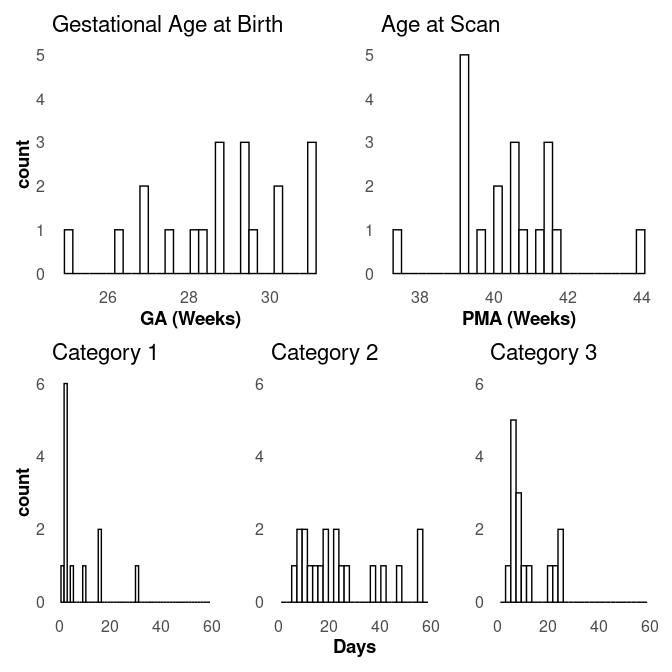

In [ ]:
#| label: dayscat
#| fig-width: 7
#| fig-height: 7
Hist_GA <- ggplot(alldata, aes(x=GA)) + 
 geom_histogram(colour="black", fill="white") + theme_minimalism() + ggtitle("Gestational Age at Birth") + xlab("GA (Weeks)") + ylim(0,5)

Hist_PMA <- ggplot(alldata, aes(x=PMA)) + 
 geom_histogram(colour="black", fill="white") + theme_minimalism() + ggtitle("Age at Scan") + xlab("PMA (Weeks)") + ylab("") + ylim(0,5)

plot_daysCat1 <- ggplot(alldata, aes(x=Invasive)) +
 geom_histogram(colour="black", fill="white", bins=50) + theme_minimalism() + ggtitle("Category 1") + xlim(0,60) + ylim(0,6) + xlab("")

plot_daysCat2 <- ggplot(alldata, aes(x=Noninvasive)) +
 geom_histogram(colour="black", fill="white") + theme_minimalism() + ggtitle("Category 2")+ xlim(0,60)+ ylim(0,6) +xlab("Days") + ylab("")

plot_daysCat3 <- ggplot(alldata, aes(x=Less_Invasive)) +
 geom_histogram(colour="black", fill="white") + theme_minimalism() + ggtitle("Category 3")+ xlim(0,60)+ ylim(0,6) +xlab("") + ylab("")

(GAHist_patch <- (Hist_GA | Hist_PMA) / (plot_daysCat1 | plot_daysCat2 | plot_daysCat3) + plot_layout(heights = c(1,1)))

In [ ]:
png(file="GAHist.png", width=7, height=7, units="in", res=300)
print(GAHist_patch)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

png 
  2 

# GA ~ Invasive

If you are born younger, are you more likely to be on more days of
invasive ventilatory support?

In [ ]:
GA_Invasive.lm <- lm(Invasive ~ GA , data=alldata)
(GA_Invasive.lm.summary <- summary(GA_Invasive.lm))


Call:
lm(formula = Invasive ~ GA, data = alldata)

Residuals:
   Min     1Q Median     3Q    Max 
-9.582 -4.187 -1.319  2.313 22.524 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  79.2115    28.4640   2.783   0.0128 *
GA           -2.5789     0.9869  -2.613   0.0182 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.016 on 17 degrees of freedom
Multiple R-squared:  0.2866,    Adjusted R-squared:  0.2446 
F-statistic: 6.829 on 1 and 17 DF,  p-value: 0.01818

In [ ]:
GA_Invasive.predict <- ggpredict(GA_Invasive.lm, terms=c("GA"), ci.lvl=0.95)

  Please use `ci_level` instead.

In [ ]:
GA_NonInvasive.lm <- lm(Noninvasive ~ GA , data=alldata)
(GA_NonInvasive.lm.summary <- summary(GA_NonInvasive.lm))


Call:
lm(formula = Noninvasive ~ GA, data = alldata)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.020  -9.119  -3.622   4.675  29.175 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  185.375     53.628   3.457  0.00301 **
GA            -5.598      1.859  -3.011  0.00787 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.22 on 17 degrees of freedom
Multiple R-squared:  0.3478,    Adjusted R-squared:  0.3095 
F-statistic: 9.066 on 1 and 17 DF,  p-value: 0.007868

In [ ]:
GA_NonInvasive.predict <- ggpredict(GA_NonInvasive.lm, terms=c("GA"), ci.lvl=0.95)

  Please use `ci_level` instead.

In [ ]:
GA_Less_Invasive.lm <- lm(Less_Invasive ~ GA , data=alldata)
(GA_Less_Invasive.lm.summary <- summary(GA_Less_Invasive.lm))


Call:
lm(formula = Less_Invasive ~ GA, data = alldata)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.2216  -4.6409  -0.5248   2.2145  16.7074 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -40.258     31.796  -1.266    0.223
GA             1.725      1.102   1.565    0.136

Residual standard error: 7.837 on 17 degrees of freedom
Multiple R-squared:  0.1259,    Adjusted R-squared:  0.0745 
F-statistic: 2.449 on 1 and 17 DF,  p-value: 0.136

In [ ]:
GA_Less_Invasive.predict <- ggpredict(GA_Less_Invasive.lm, terms=c("GA"), ci.lvl=0.95)

  Please use `ci_level` instead.

In [ ]:
Cat1_v_GAplot <- ggplot() + geom_point(data = alldata, aes(x = GA, y = Invasive))  +
  geom_smooth(data=alldata, aes(x = GA, y = Invasive), method="lm", colour="grey", size=0.5, alpha=0.3) +
  geom_ribbon(data=GA_Invasive.predict, aes(x=x, ymin=conf.low, ymax=conf.high),  alpha=0.15) +
  geom_line(data=GA_Invasive.predict, aes(x=x, y=conf.high),  linetype="dashed")+
  geom_line(data=GA_Invasive.predict, aes(x=x, y=conf.low),  linetype="dashed")+
  geom_line(data=GA_Invasive.predict, aes(x,predicted))+
  annotate(geom="text", x=29.5, y=25, label=paste("Adj R Sq = ", round(GA_Invasive.lm.summary$adj.r.squared,2), "\np = ", round(GA_Invasive.lm.summary$coefficients[2,4],2))) +
  ylab("Days on Category 1") + ylim(-7,33) + xlab("GA (Weeks)") +
theme_minimalism()

ℹ Please use `linewidth` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

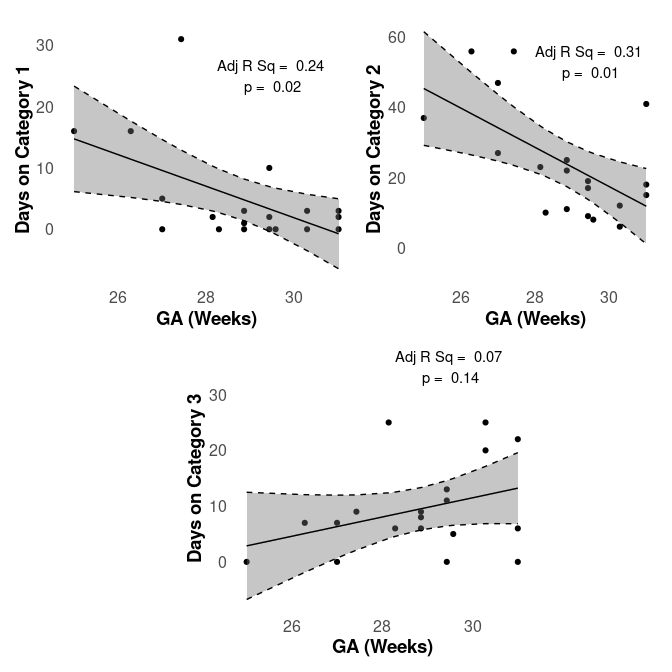

In [ ]:
#| label: linreg
#| fig-width: 7
#| fig-height: 7
design <- "AABB
           #CC#"
(Cat_v_GA_patch <- Cat1_v_GAplot + Cat2_v_GAplot + Cat3_v_GAplot +
  plot_layout(design = design))

In [ ]:
png(file="Categories_vs_GA.png", width=7, height=7, units="in", res=300)
dev.off()

png 
  2 

# Tissue Volume ~ PMA

In [ ]:
# Select columns ending with "_Volume"
volume_cols <- grep("_Volume$", colnames(alldata), perl=TRUE)

# Divide values by 1000 using lapply
alldata[, volume_cols] <- lapply(alldata[, volume_cols], function(x) x / 1000)

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

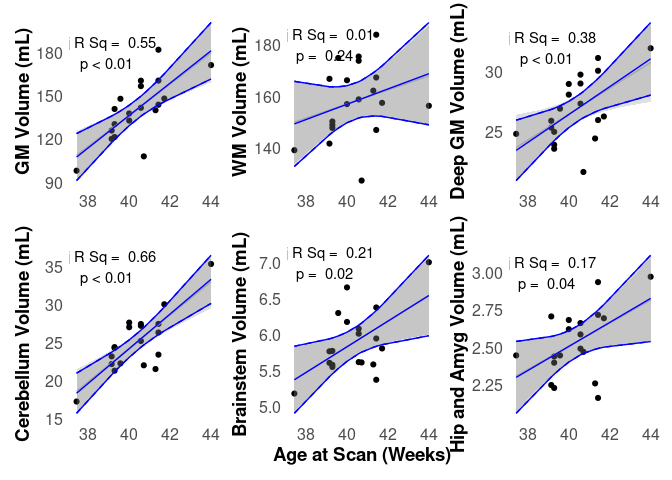

In [ ]:
Volume.lm <- lm(GM_Volume ~ GA + PMA, data=alldata)
Volume.lm.summary <- summary(Volume.lm)
Volume.predict <- ggpredict(Volume.lm, terms=c("PMA"), ci.lvl=0.95)

# CBF ~ Invasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

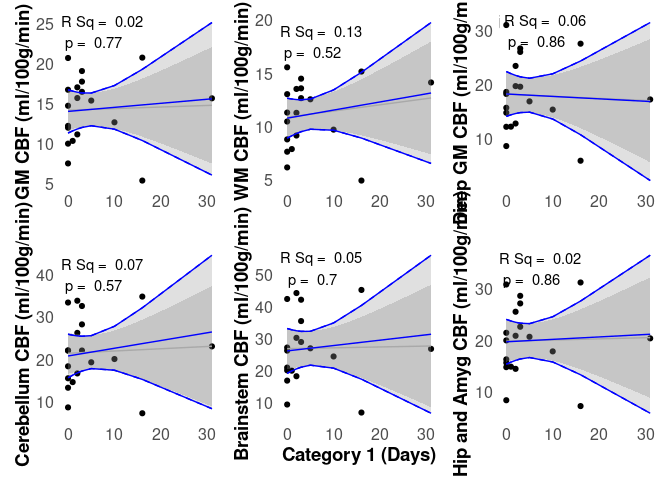

In [ ]:
GMCBF_Invasive.lm <- lm(GM_CBF ~ GA + PMA + Invasive, data=alldata)
CBF_Invasive.lm.summary <- summary(GMCBF_Invasive.lm)
GMCBF_Invasive.lm.summary = CBF_Invasive.lm.summary
CBF_Invasive.predict <- ggpredict(GMCBF_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

# CBF ~ Noninvasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

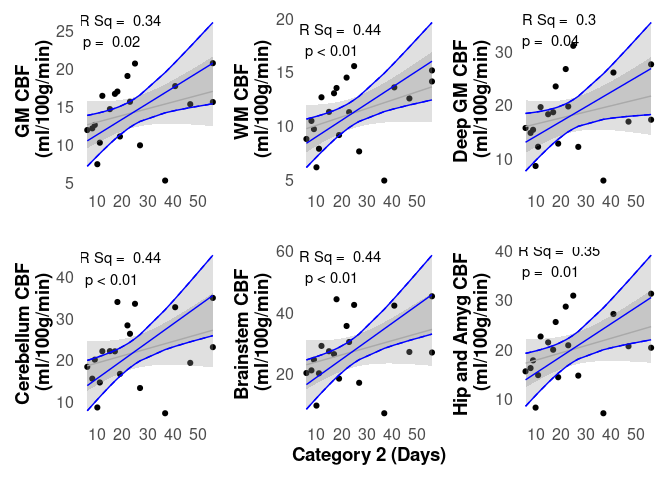

In [ ]:
GMCBF_Noninvasive.lm <- lm(GM_CBF ~ PMA + GA + Noninvasive, data=alldata)
CBF_Noninvasive.lm.summary <- summary(GMCBF_Noninvasive.lm)
GMCBF_Noninvasive.lm.summary = CBF_Noninvasive.lm.summary
CBF_Noninvasive.predict <- ggpredict(GMCBF_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

# CBF ~ Less Invasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

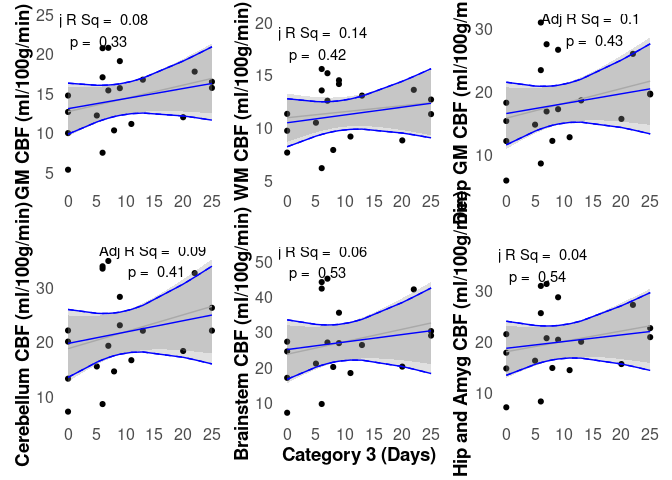

In [ ]:
GMCBF_Less_Invasive.lm <- lm(GM_CBF ~ PMA + GA + Less_Invasive, data=alldata)
CBF_Less_Invasive.lm.summary <- summary(GMCBF_Less_Invasive.lm)
GMCBF_Less_Invasive.lm.summary = CBF_Less_Invasive.lm.summary
CBF_Less_Invasive.predict <- ggpredict(GMCBF_Less_Invasive.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

# CBF ~ Roomair

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

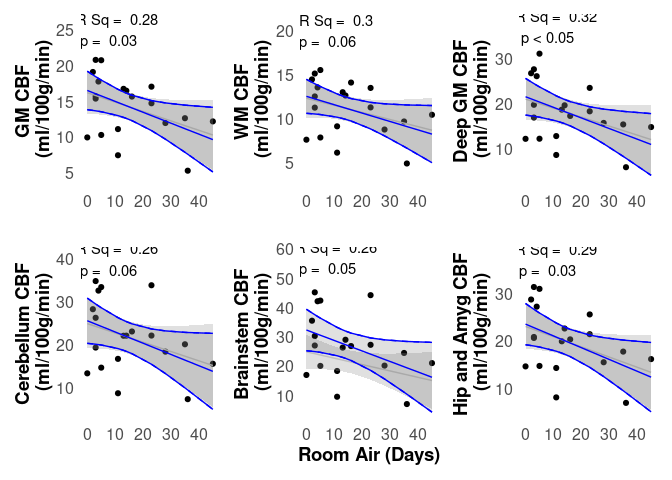

In [ ]:
GMCBF_roomair.lm <- lm(GM_CBF ~ PMA + GA + roomair, data=alldata)
CBF_roomair.lm.summary <- summary(GMCBF_roomair.lm)
GMCBF_roomair.lm.summary = CBF_roomair.lm.summary
CBF_roomair.predict <- ggpredict(GMCBF_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# CBF ~ Total Vent

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

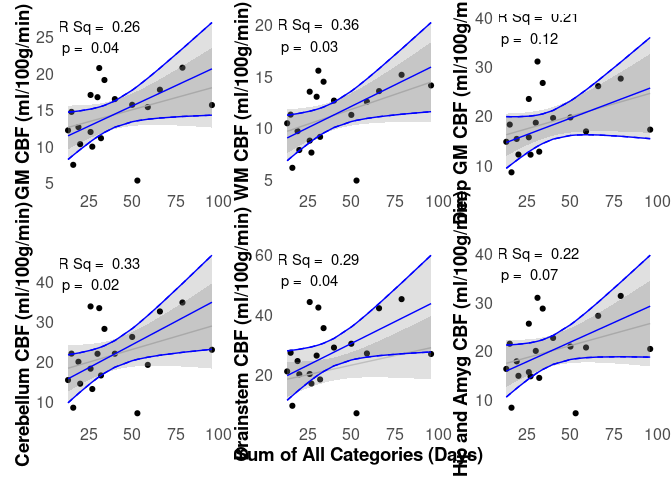

In [ ]:
CBF_Vent.lm <- lm(GM_CBF ~ PMA + GA + Total_vent, data=alldata)
CBF_Vent.lm.summary <- summary(CBF_Vent.lm)
CBF_Vent.predict <- ggpredict(CBF_Vent.lm, terms=c("Total_vent"), ci.lvl=0.95)

# CBF ~ Porportion of days on ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

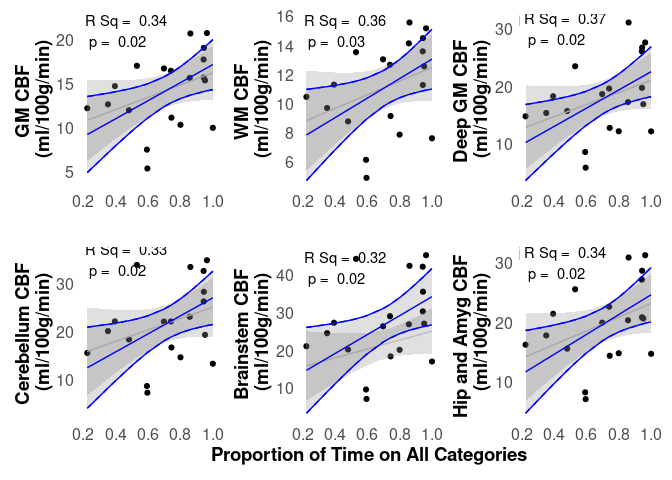

In [ ]:
GMCBF_Vent_P.lm <- lm(GM_CBF ~ PMA + GA + Vent_P, data=alldata)
CBF_Vent_P.lm.summary <- summary(GMCBF_Vent_P.lm)
GMCBF_Vent_P.lm.summary = CBF_Vent_P.lm.summary
CBF_Vent_P.predict <- ggpredict(GMCBF_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

# CBF ~ Percent of Days on Invasive Ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

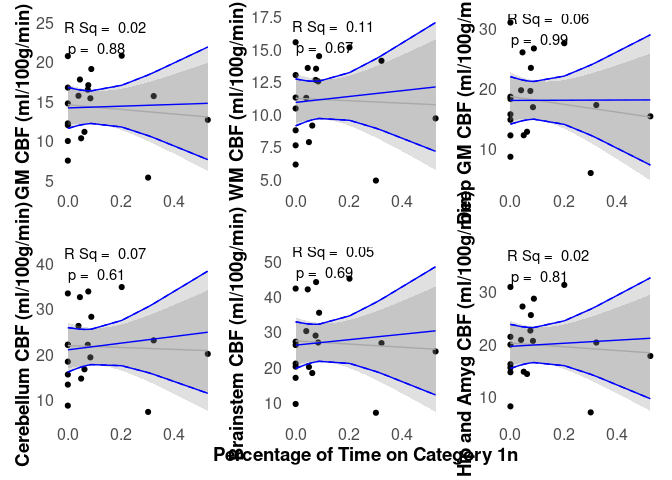

In [ ]:
CBF_IN_P.lm <- lm(GM_CBF ~ PMA + GA + IN_P , data=alldata)
CBF_IN_P.lm.summary <- summary(CBF_IN_P.lm)
CBF_IN_P.predict <- ggpredict(CBF_IN_P.lm, terms=c("IN_P"), ci.lvl=0.95)

# CBF ~ Percent of Days on Noninvasive Ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

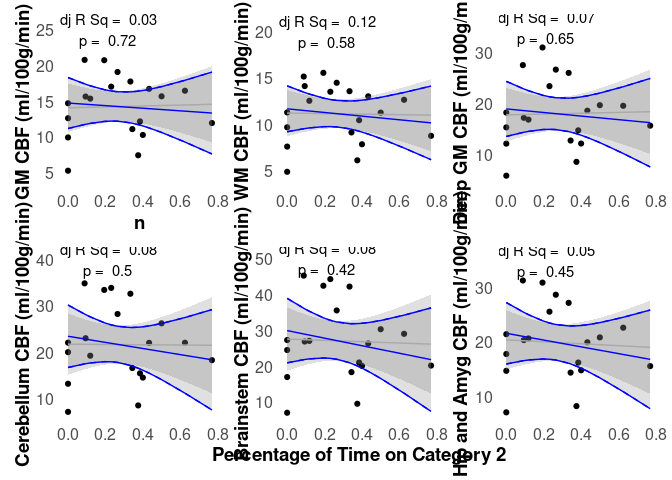

In [ ]:
CBF_NI_P.lm <- lm(GM_CBF ~ PMA + GA + NI_P , data=alldata)
CBF_NI_P.lm.summary <- summary(CBF_NI_P.lm)
CBF_NI_P.predict <- ggpredict(CBF_NI_P.lm, terms=c("NI_P"), ci.lvl=0.95)

# CBF ~ Percent of Days on Less Invasive Ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'

Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'

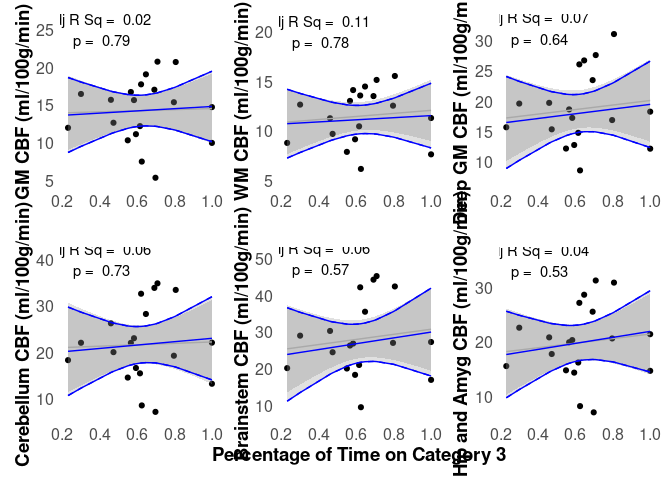

In [ ]:
CBF_LI_P.lm <- lm(GM_CBF ~ PMA + GA + LI_P , data=alldata)
CBF_LI_P.lm.summary <- summary(CBF_LI_P.lm)
CBF_LI_P.predict <- ggpredict(CBF_LI_P.lm, terms=c("LI_P"), ci.lvl=0.95)

# CMRO2 ~ Invasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

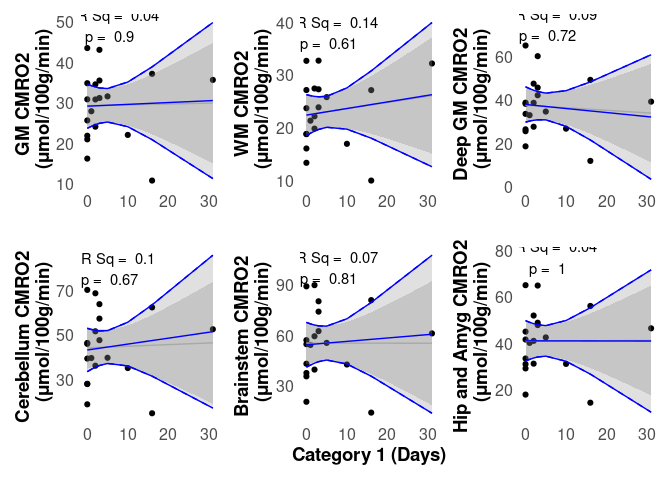

In [ ]:
GMCMRO2_Invasive.lm <- lm(GM_CMRO2 ~ PMA + GA + Invasive, data=alldata)
CMRO2_Invasive.lm.summary <- summary(GMCMRO2_Invasive.lm)
GMCMRO2_Invasive.lm.summary = CMRO2_Invasive.lm.summary
CMRO2_Invasive.predict <- ggpredict(GMCMRO2_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

# CMRO2 ~ Noninvasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

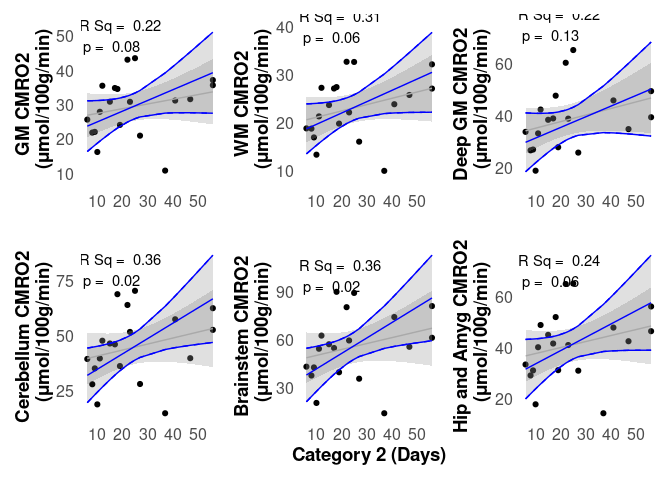

In [ ]:
GMCMRO2_Noninvasive.lm <- lm(GM_CMRO2 ~ PMA + GA + Noninvasive, data=alldata)
CMRO2_Noninvasive.lm.summary <- summary(GMCMRO2_Noninvasive.lm)
GMCMRO2_Noninvasive.lm.summary = CMRO2_Noninvasive.lm.summary
CMRO2_Noninvasive.predict <- ggpredict(GMCMRO2_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

# CMRO2 ~ Less Invasive

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

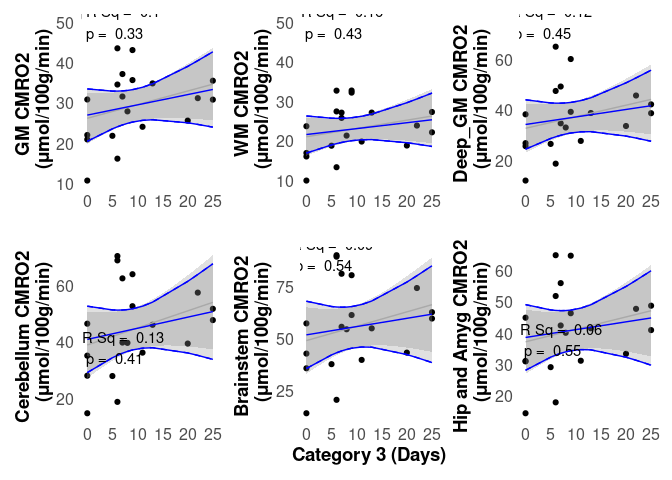

In [ ]:
GMCMRO2_Less_Invasive.lm <- lm(GM_CMRO2 ~ PMA + GA + Less_Invasive, data=alldata)
CMRO2_Less_Invasive.lm.summary <- summary(GMCMRO2_Less_Invasive.lm)
GMCMRO2_Less_Invasive.lm.summary = CMRO2_Less_Invasive.lm.summary
CMRO2_Less_Invasive.predict <- ggpredict(GMCMRO2_Less_Invasive.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

# CMRO2 ~ Roomair

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

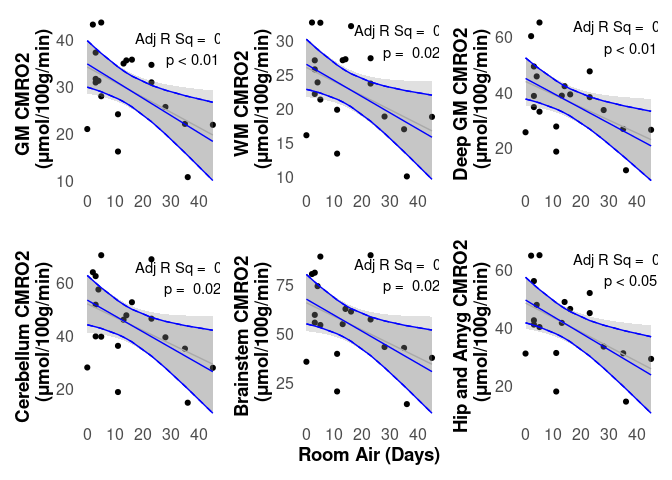

In [ ]:
GMCMRO2_roomair.lm <- lm(GM_CMRO2 ~ PMA + GA + roomair, data=alldata)
CMRO2_roomair.lm.summary <- summary(GMCMRO2_roomair.lm)
GMCMRO2_roomair.lm.summary = CMRO2_roomair.lm.summary
CMRO2_roomair.predict <- ggpredict(GMCMRO2_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# CMRO2 ~ Total Vent

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

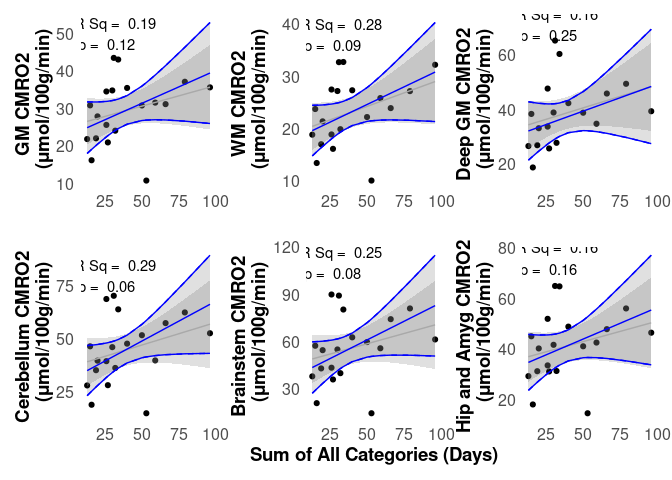

In [ ]:
CMRO2_Vent.lm <- lm(GM_CMRO2 ~ PMA + GA + Total_vent, data=alldata)
CMRO2_Vent.lm.summary <- summary(CMRO2_Vent.lm)
CMRO2_Vent.predict <- ggpredict(CMRO2_Vent.lm, terms=c("Total_vent"), ci.lvl=0.95)

# CMRO2 ~ Porportion of days on ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

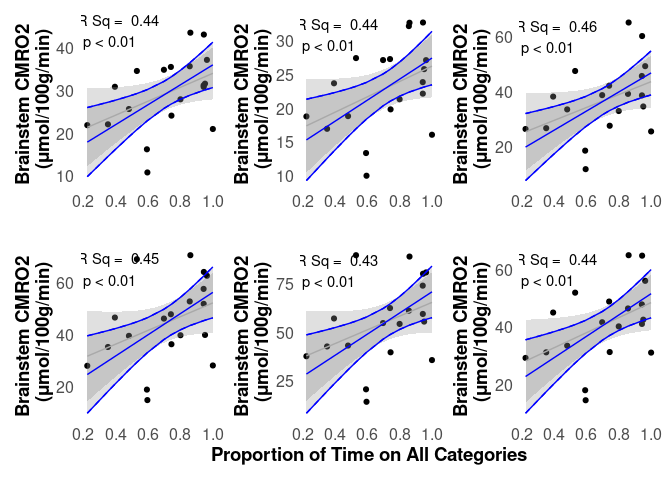

In [ ]:
GMCMRO2_Vent_P.lm <- lm(GM_CMRO2 ~ PMA + GA + Vent_P, data=alldata)
CMRO2_Vent_P.lm.summary <- summary(GMCMRO2_Vent_P.lm)
GMCMRO2_Vent_P.lm.summary = CMRO2_Vent_P.lm.summary
CMRO2_Vent_P.predict <- ggpredict(GMCMRO2_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

# CMRO2 ~ Percent of days on invasive ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'

Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'

Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).

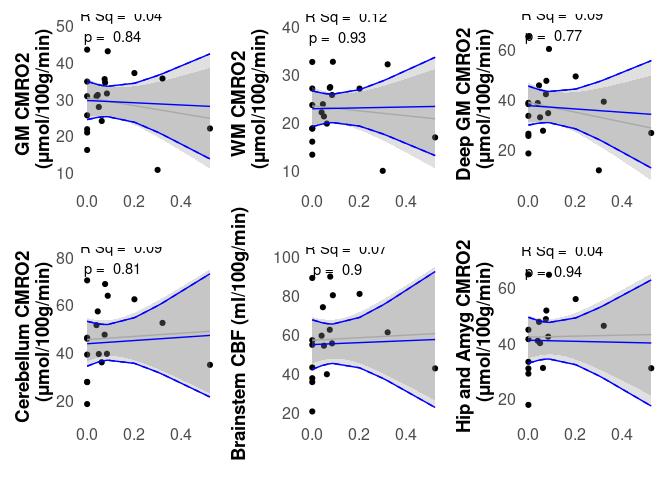

In [ ]:
CMRO2_IN_P.lm <- lm(GM_CMRO2 ~ PMA + GA + IN_P , data=alldata)
CMRO2_IN_P.lm.summary <- summary(CMRO2_IN_P.lm)
CMRO2_IN_P.predict <- ggpredict(CMRO2_IN_P.lm, terms=c("IN_P"), ci.lvl=0.95)

# CMRO2 ~ Percent of Days on Noninvasive Ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

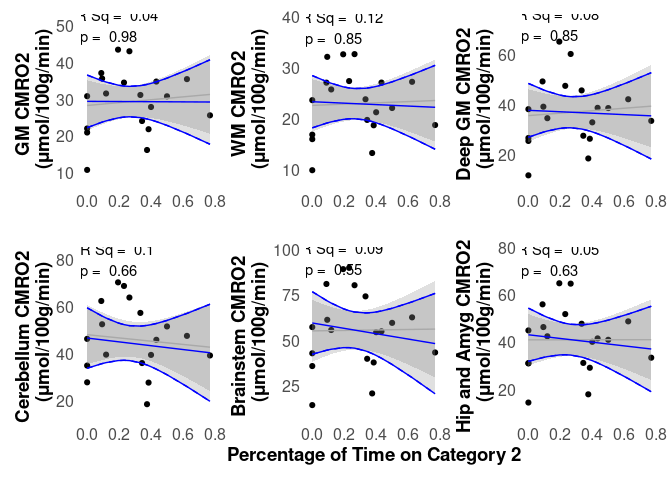

In [ ]:
CMRO2_NI_P.lm <- lm(GM_CMRO2 ~ PMA + GA + NI_P , data=alldata)
CMRO2_NI_P.lm.summary <- summary(CMRO2_NI_P.lm)
CMRO2_NI_P.predict <- ggpredict(CMRO2_NI_P.lm, terms=c("NI_P"), ci.lvl=0.95)

# CMRO2 ~ Percent of Days on Less Invasive Ventilation

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

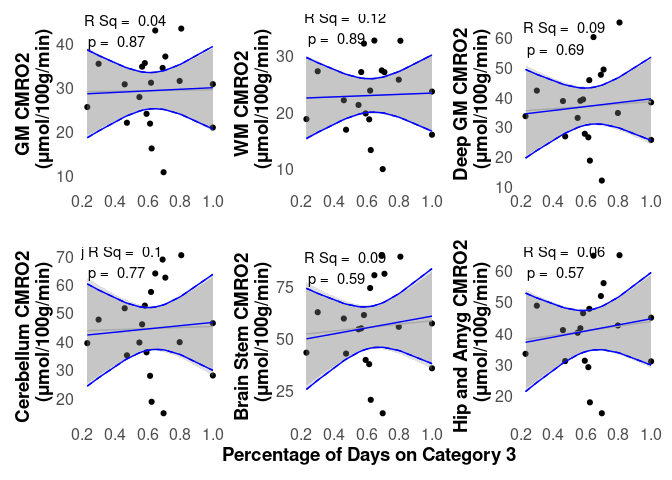

In [ ]:
CMRO2_LI_P.lm <- lm(GM_CMRO2 ~ PMA + GA + LI_P , data=alldata)
CMRO2_LI_P.lm.summary <- summary(CMRO2_LI_P.lm)
CMRO2_LI_P.predict <- ggpredict(CMRO2_LI_P.lm, terms=c("LI_P"), ci.lvl=0.95)

# Patchwork Plots

## Proportion

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

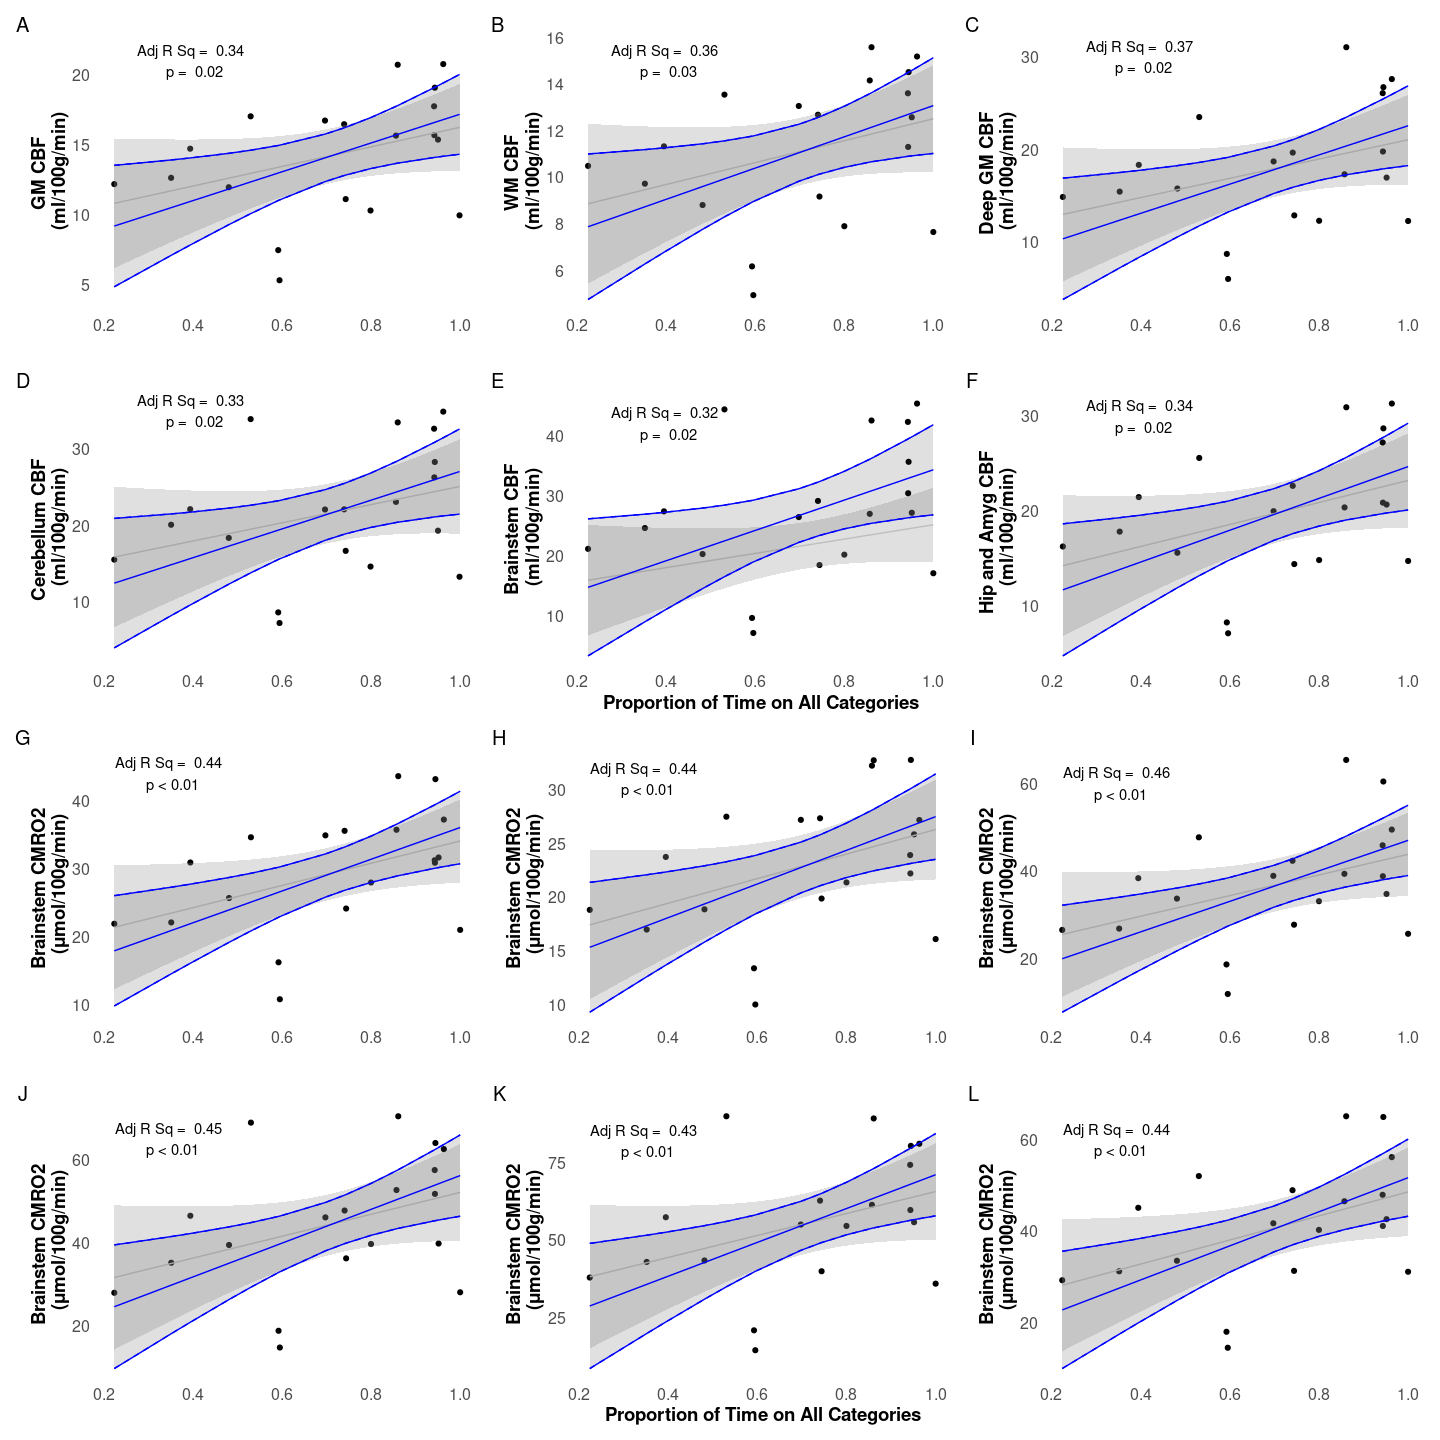

In [ ]:
#| label: proportion
#| fig-width: 15
#| fig-height: 15
(CBFandCMRO2_v_ProportionVent <- CBF_v_VentPerc_patch / CMRO2_v_PropVent_patch + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 15)))

In [ ]:
ggsave('CBFandCMRO2vProportionVent.png', width=15, height=15, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

## Category 2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

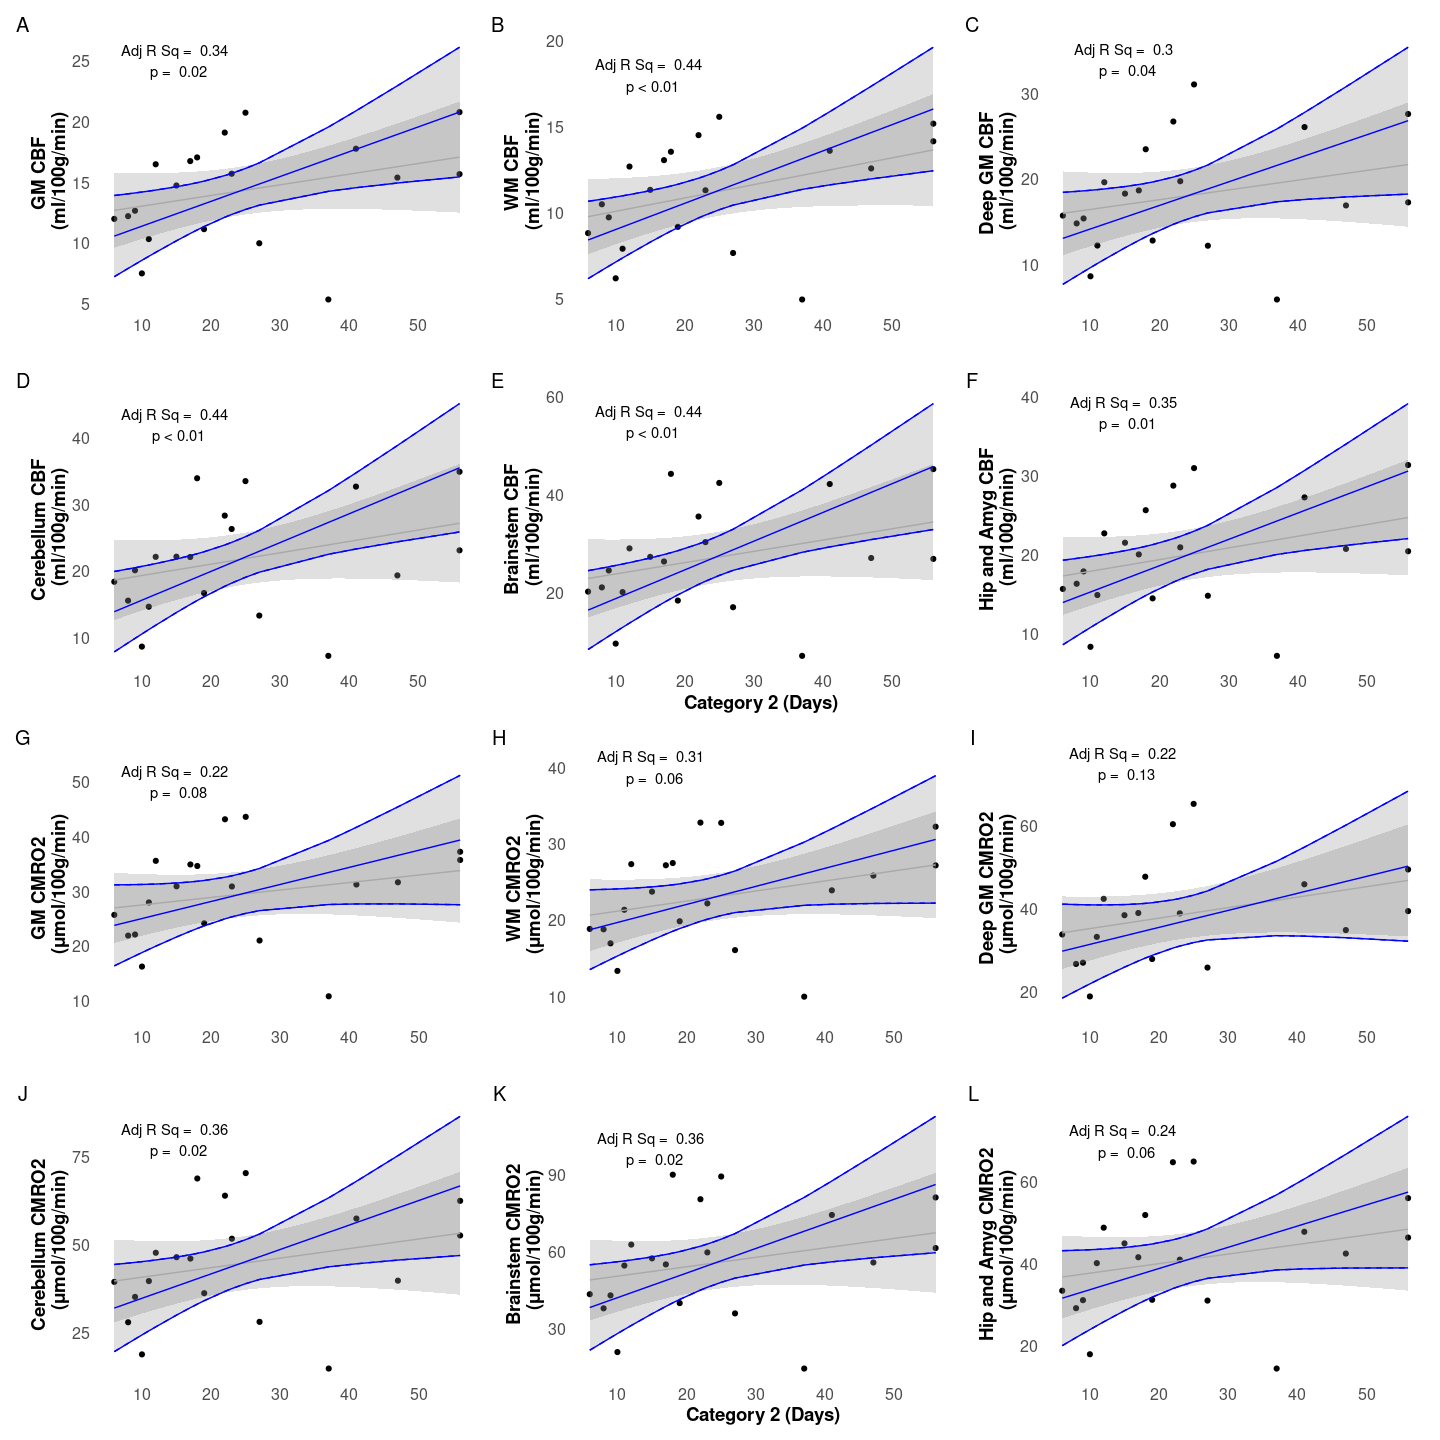

In [ ]:
#| label: cat2
#| fig-width: 15
#| fig-height: 15

(CBFandCMRO2_v_Category2 <- CBF_v_NonInvasive_patch / CMRO2_v_NonInvasive_patch + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 15)))

In [ ]:
ggsave('CBFandCMRO2vCategory2.png', width=15, height=15, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

## Roomair

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

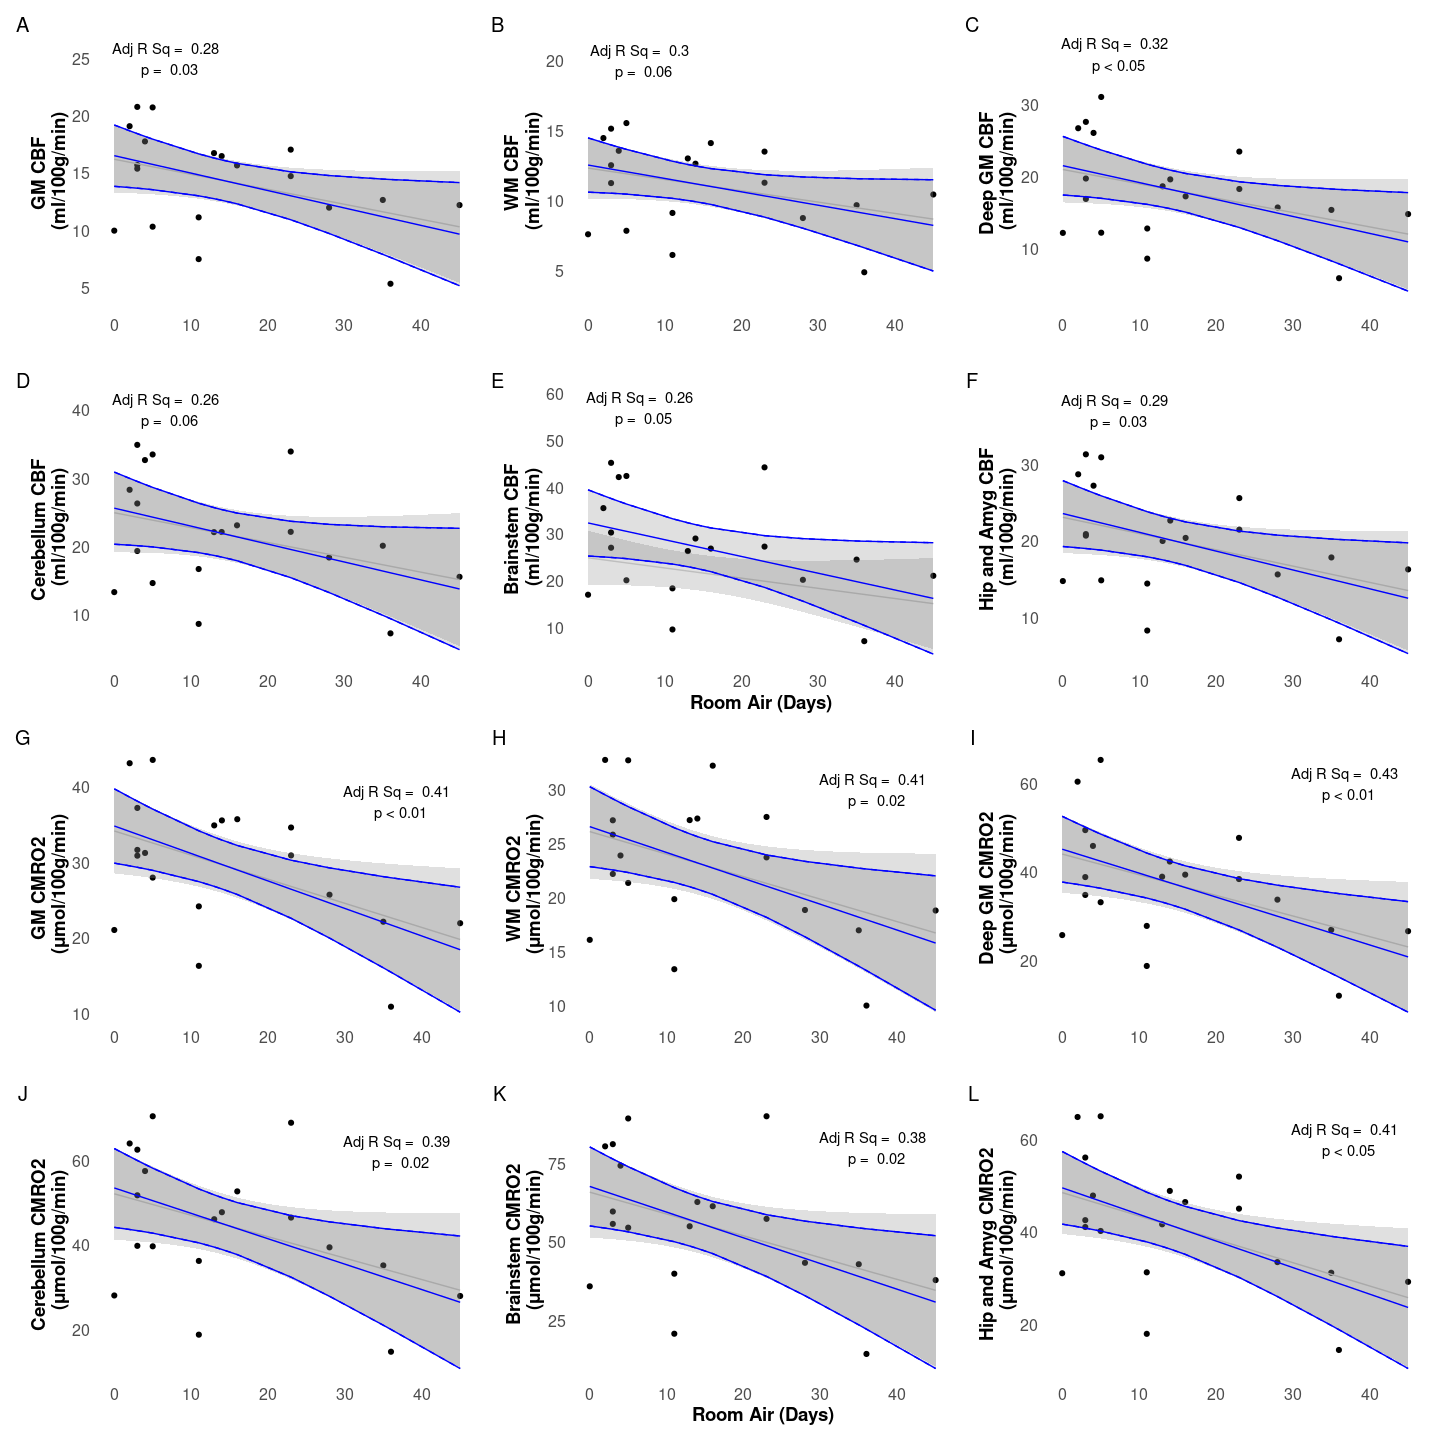

In [ ]:
#| label: roomair
#| fig-width: 15
#| fig-height: 15
(CBFandCMRO2_v_Roomair <- CBF_v_Roomair_patch / CMRO2_v_roomair_patch + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 15)))

In [ ]:
ggsave('CBFandCMRO2vRoomair.png', width=15, height=15, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

# CSVO2

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

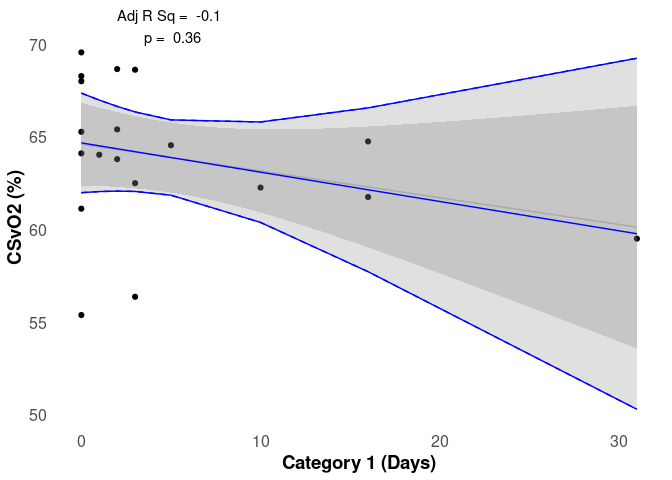

In [ ]:
CSvO2_Invasive.lm <- lm(CSvO2_P ~ PMA + GA + Invasive , data=alldata)
CSvO2_Invasive.lm.summary <- summary(CSvO2_Invasive.lm)
CSvO2_Invasive.predict <- ggpredict(CSvO2_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

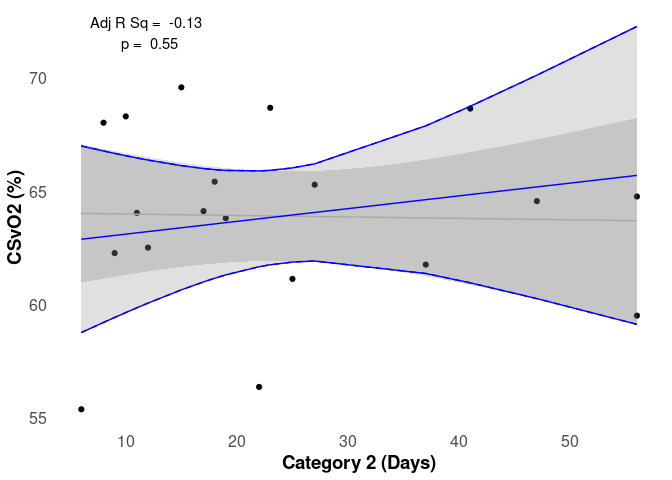

In [ ]:
CSvO2_Noninvasive.lm <- lm(CSvO2_P ~ PMA + GA + Noninvasive , data=alldata)
CSvO2_Noninvasive.lm.summary <- summary(CSvO2_Noninvasive.lm)
CSvO2_Noninvasive.predict <- ggpredict(CSvO2_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

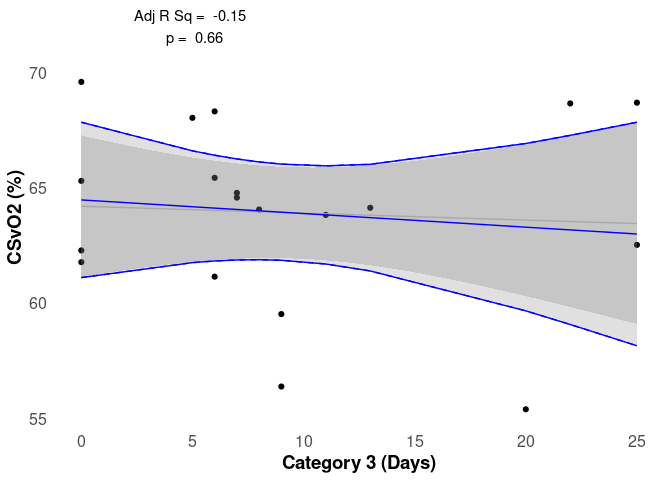

In [ ]:
CSvO2_Less_Invasive.lm <- lm(CSvO2_P ~ PMA + GA + Less_Invasive , data=alldata)
CSvO2_Less_Invasive.lm.summary <- summary(CSvO2_Less_Invasive.lm)
CSvO2_Less_Invasive.predict <- ggpredict(CSvO2_Less_Invasive.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

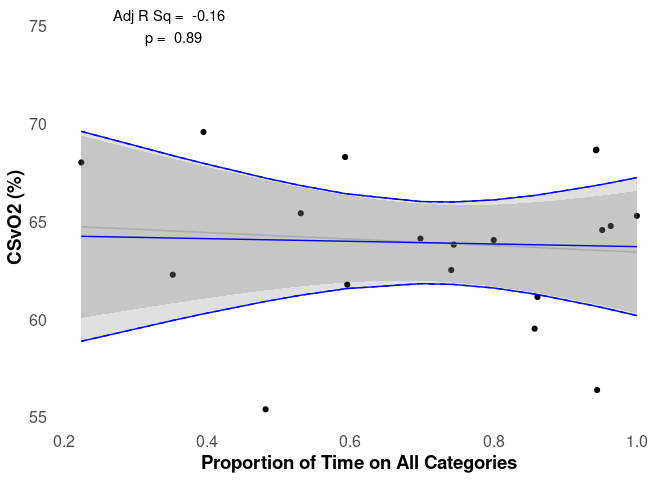

In [ ]:
CSvO2_Vent_P.lm <- lm(CSvO2_P ~ PMA + GA + Vent_P , data=alldata)
CSvO2_Vent_P.lm.summary <- summary(CSvO2_Vent_P.lm)
CSvO2_Vent_P.predict <- ggpredict(CSvO2_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

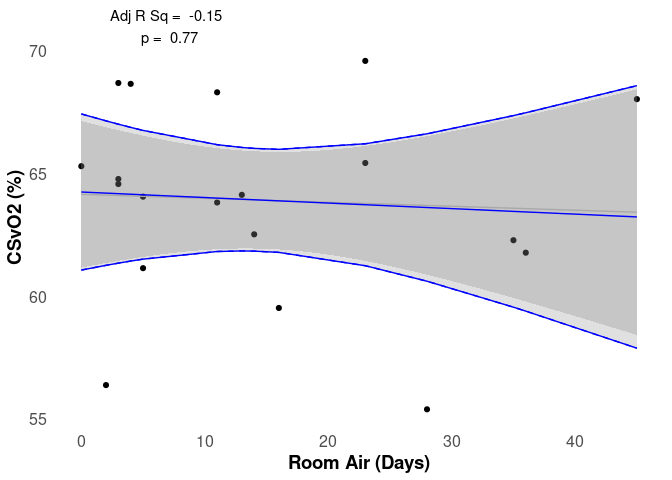

In [ ]:
CSvO2_roomair.lm <- lm(CSvO2_P ~ PMA + GA + roomair , data=alldata)
CSvO2_roomair.lm.summary <- summary(CSvO2_roomair.lm)
CSvO2_roomair.predict <- ggpredict(CSvO2_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# CSaO2

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

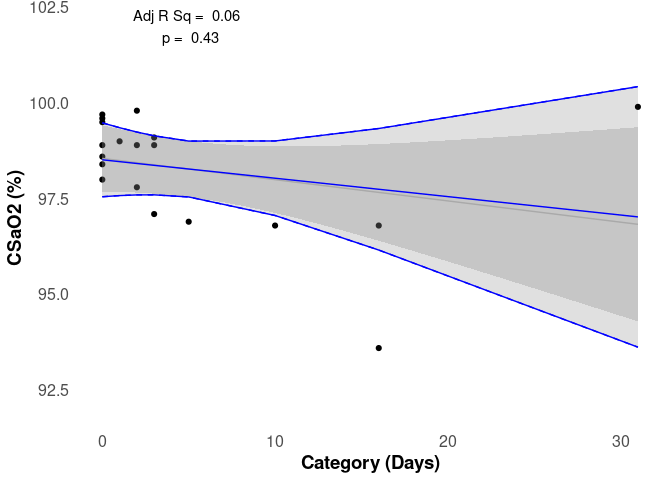

In [ ]:
CSaO2_Invasive.lm <- lm(CSaO2_P ~ PMA + GA + Invasive , data=alldata)
CSaO2_Invasive.lm.summary <- summary(CSaO2_Invasive.lm)
CSaO2_Invasive.predict <- ggpredict(CSaO2_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

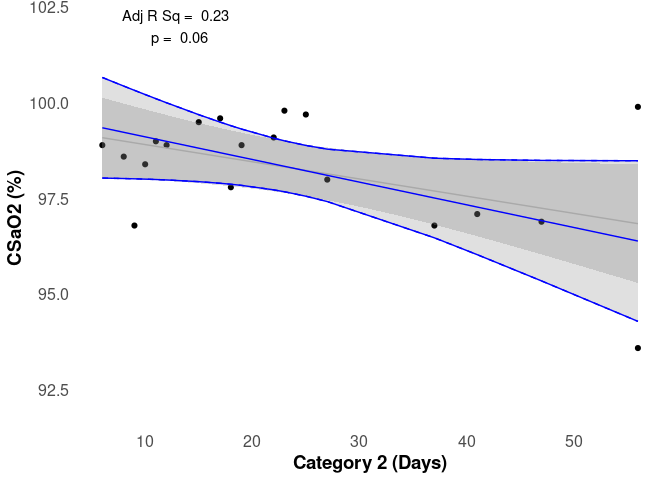

In [ ]:
CSaO2_Noninvasive.lm <- lm(CSaO2_P ~ PMA + GA + Noninvasive , data=alldata)
CSaO2_Noninvasive.lm.summary <- summary(CSaO2_Noninvasive.lm)
CSaO2_Noninvasive.predict <- ggpredict(CSaO2_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

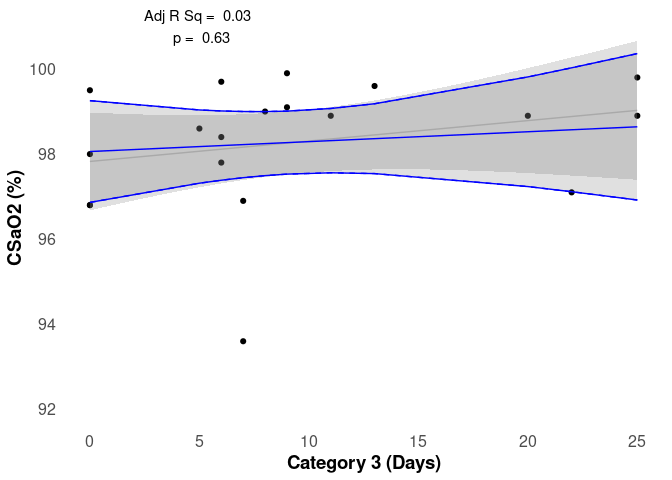

In [ ]:
CSaO2_LI.lm <- lm(CSaO2_P ~ PMA + GA + Less_Invasive , data=alldata)
CSaO2_LI.lm.summary <- summary(CSaO2_LI.lm)
CSaO2_LI.predict <- ggpredict(CSaO2_LI.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

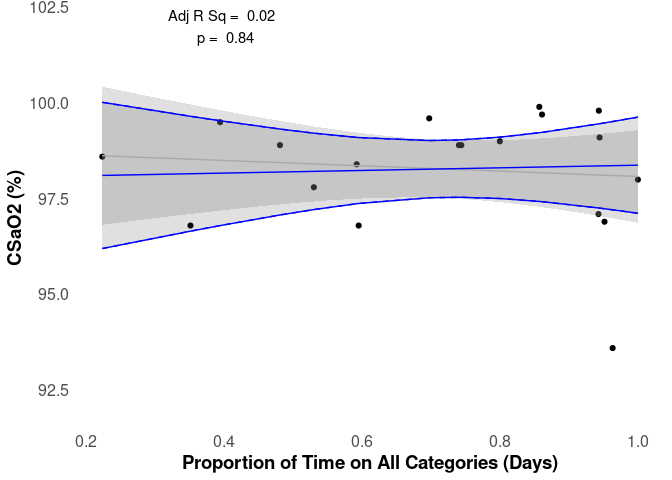

In [ ]:
CSaO2_Vent_P.lm <- lm(CSaO2_P ~ PMA + GA + Vent_P , data=alldata)
CSaO2_Vent_P.lm.summary <- summary(CSaO2_Vent_P.lm)
CSaO2_Vent_P.predict <- ggpredict(CSaO2_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

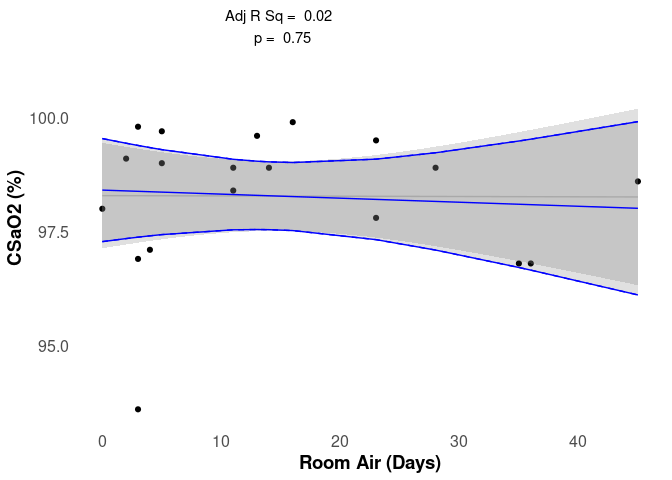

In [ ]:
CSaO2_roomair.lm <- lm(CSaO2_P ~ PMA + GA + roomair , data=alldata)
CSaO2_roomair.lm.summary <- summary(CSaO2_roomair.lm)
CSaO2_roomair.predict <- ggpredict(CSaO2_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# Hct

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

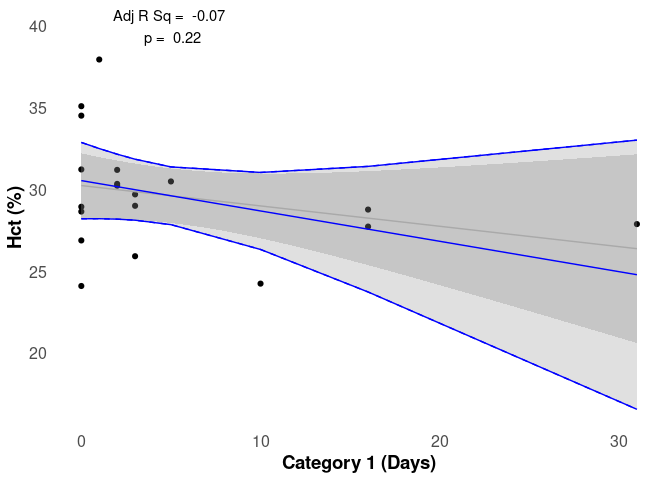

In [ ]:
Hct_P_Invasive.lm <- lm(Hct_P ~ PMA + GA + Invasive , data=alldata)
Hct_P_Invasive.lm.summary <- summary(Hct_P_Invasive.lm)
Hct_P_Invasive.predict <- ggpredict(Hct_P_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

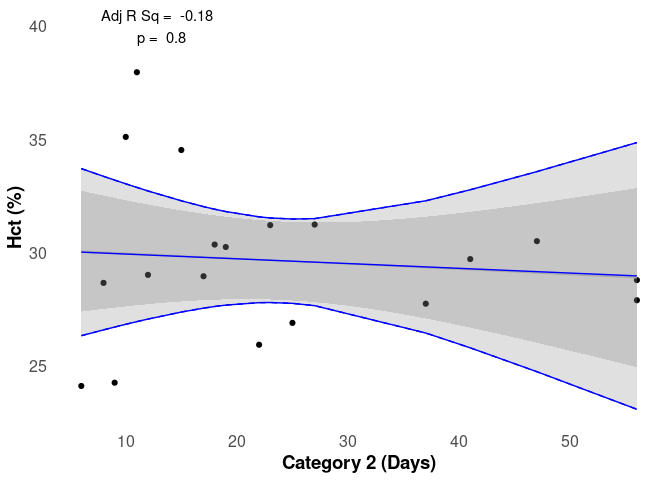

In [ ]:
Hct_P_Noninvasive.lm <- lm(Hct_P ~ PMA + GA + Noninvasive , data=alldata)
Hct_P_Noninvasive.lm.summary <- summary(Hct_P_Noninvasive.lm)
Hct_P_Noninvasive.predict <- ggpredict(Hct_P_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

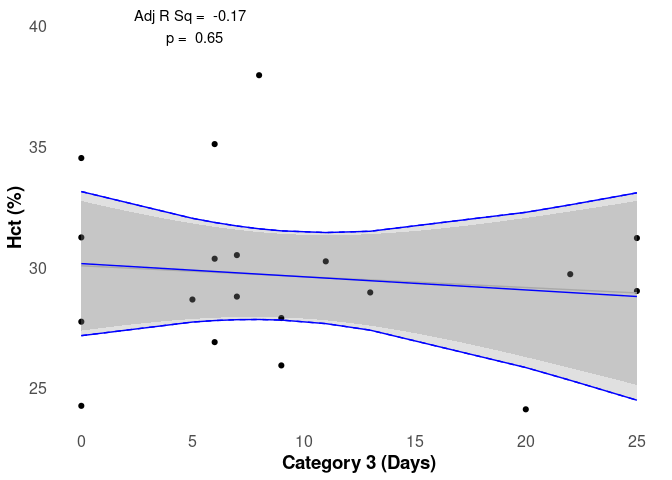

In [ ]:
Hct_P_Less_Invasive.lm <- lm(Hct_P ~ PMA + GA + Less_Invasive , data=alldata)
Hct_P_Less_Invasive.lm.summary <- summary(Hct_P_Less_Invasive.lm)
Hct_P_Less_Invasive.predict <- ggpredict(Hct_P_Less_Invasive.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

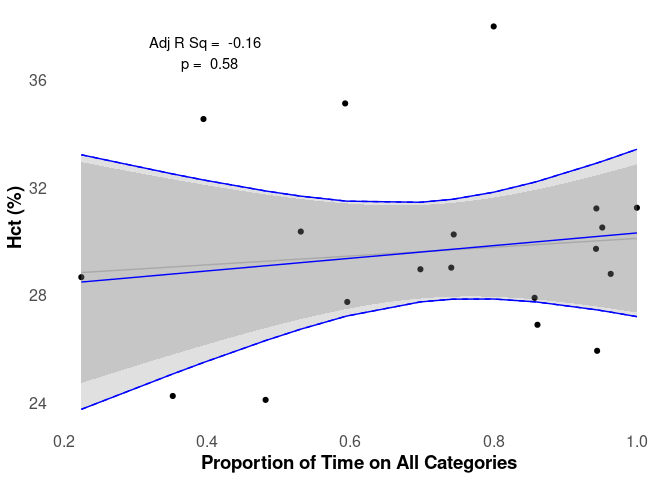

In [ ]:
Hct_P_Vent_P.lm <- lm(Hct_P ~ PMA + GA + Vent_P , data=alldata)
Hct_P_Vent_P.lm.summary <- summary(Hct_P_Vent_P.lm)
Hct_P_Vent_P.predict <- ggpredict(Hct_P_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

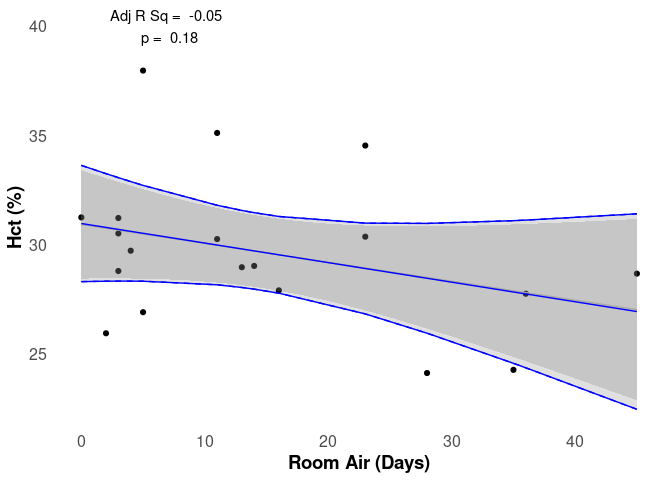

In [ ]:
Hct_P_roomair.lm <- lm(Hct_P ~ PMA + GA + roomair , data=alldata)
Hct_P_roomair.lm.summary <- summary(Hct_P_roomair.lm)
Hct_P_roomair.predict <- ggpredict(Hct_P_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# OEF

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

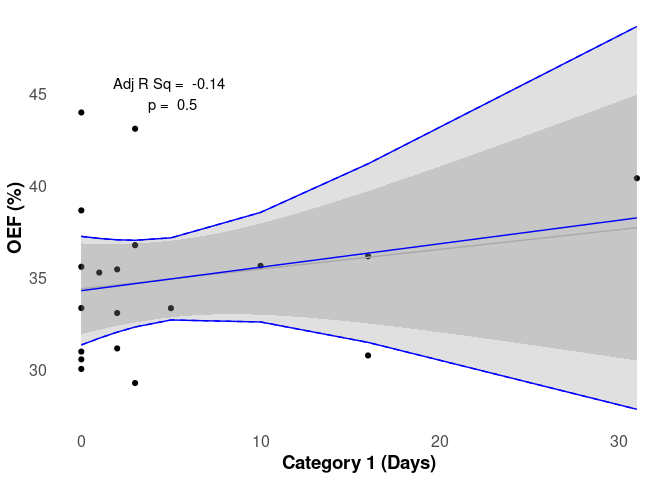

In [ ]:
OEF_P_Invasive.lm <- lm(OEF_P ~ PMA + GA + Invasive , data=alldata)
OEF_P_Invasive.lm.summary <- summary(OEF_P_Invasive.lm)
OEF_P_Invasive.predict <- ggpredict(OEF_P_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

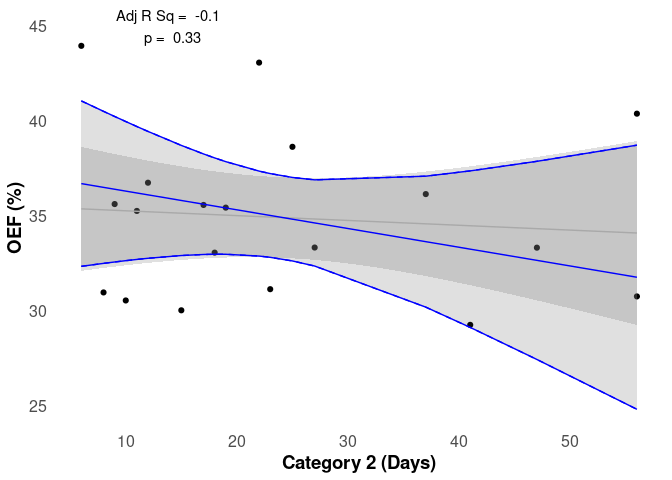

In [ ]:
OEF_P_Noninvasive.lm <- lm(OEF_P ~ PMA + GA + Noninvasive , data=alldata)
OEF_P_Noninvasive.lm.summary <- summary(OEF_P_Noninvasive.lm)
OEF_P_Noninvasive.predict <- ggpredict(OEF_P_Noninvasive.lm, terms=c("Noninvasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

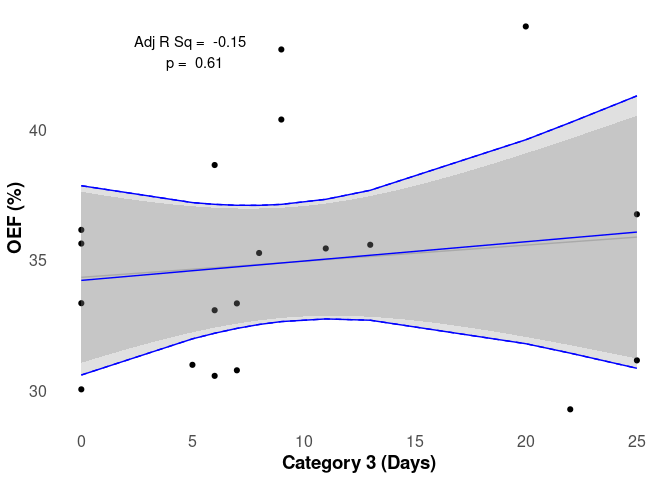

In [ ]:
OEF_P_Less_Invasive.lm <- lm(OEF_P ~ PMA + GA + Less_Invasive , data=alldata)
OEF_P_Less_Invasive.lm.summary <- summary(OEF_P_Less_Invasive.lm)
OEF_P_Less_Invasive.predict <- ggpredict(OEF_P_Less_Invasive.lm, terms=c("Less_Invasive"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

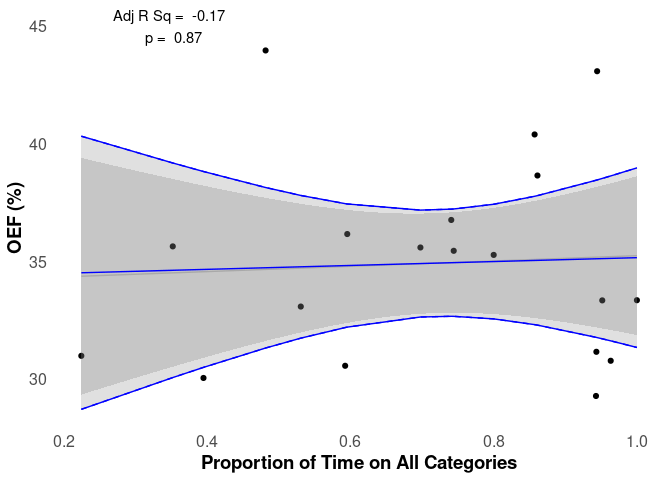

In [ ]:
OEF_P_Vent_P.lm <- lm(OEF_P ~ PMA + GA + Vent_P , data=alldata)
OEF_P_Vent_P.lm.summary <- summary(OEF_P_Vent_P.lm)
OEF_P_Vent_P.predict <- ggpredict(OEF_P_Vent_P.lm, terms=c("Vent_P"), ci.lvl=0.95)

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

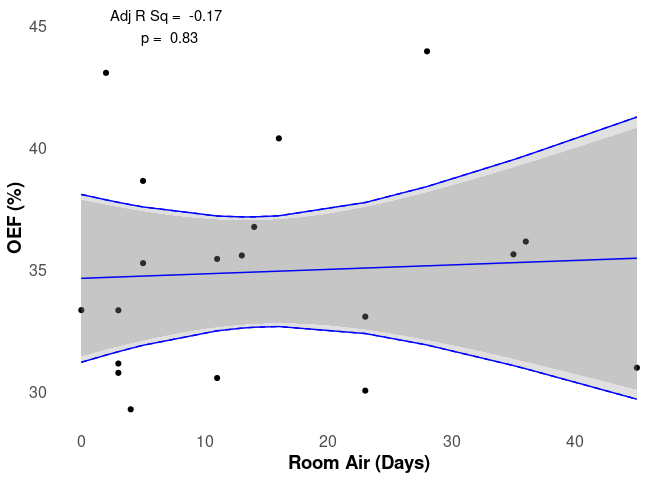

In [ ]:
OEF_P_roomair.lm <- lm(OEF_P ~ PMA + GA + roomair , data=alldata)
OEF_P_roomair.lm.summary <- summary(OEF_P_roomair.lm)
OEF_P_roomair.predict <- ggpredict(OEF_P_roomair.lm, terms=c("roomair"), ci.lvl=0.95)

# Volume ~ Invasive

## Brain Stem

  Please use `ci_level` instead.

`geom_smooth()` using formula = 'y ~ x'

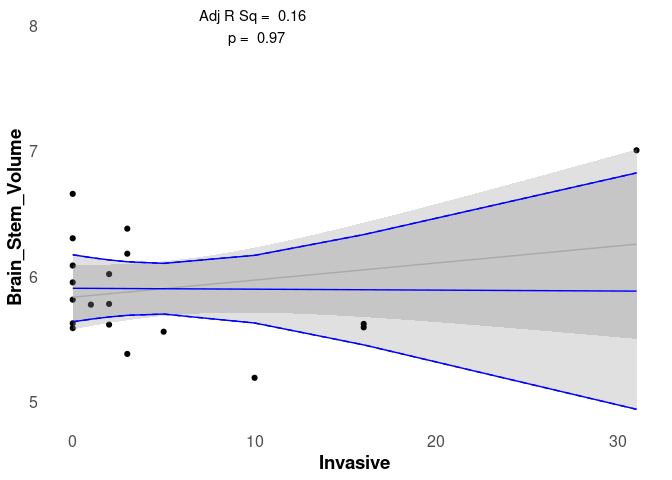

In [ ]:
Volume_Invasive.lm <- lm(Brain_Stem_Volume ~ PMA + GA + Invasive , data=alldata)
Volume_Invasive.lm.summary <- summary(Volume_Invasive.lm)
Volume_Invasive.predict <- ggpredict(Volume_Invasive.lm, terms=c("Invasive"), ci.lvl=0.95)

# Tables

## CBF

| ROI        | Category 1                    |
|------------|-------------------------------|
| CGM        | 0.05 \[-0.31 to 0.41\] / 0.02 |
| WM         | 0.08 \[-0.17 to 0.32\] / 0.13 |
| DeepGM     | -0.05 \[-0.59 to 0.5\] / 0.06 |
| Cerebellum | 0.18 \[-0.5 to 0.87\] / 0.07  |
| Brainstem  | 0.17 \[-0.75 to 1.09\] / 0.05 |
| Hipandamyg | 0.05 \[-0.53 to 0.63\] / 0.02 |

| ROI        | Category 2                   |
|------------|------------------------------|
| CGM        | 0.2 \[0.05 to 0.36\] / 0.34  |
| WM         | 0.15 \[0.05 to 0.26\] / 0.44 |
| DeepGM     | 0.28 \[0.02 to 0.53\] / 0.3  |
| Cerebellum | 0.43 \[0.14 to 0.72\] / 0.44 |
| Brainstem  | 0.59 \[0.2 to 0.97\] / 0.44  |
| Hipandamyg | 0.33 \[0.08 to 0.59\] / 0.35 |

| ROI        | Category 3                    |
|------------|-------------------------------|
| CGM        | 0.13 \[-0.14 to 0.4\] / 0.08  |
| WM         | 0.07 \[-0.12 to 0.26\] / 0.14 |
| DeepGM     | 0.16 \[-0.26 to 0.57\] / 0.1  |
| Cerebellum | 0.21 \[-0.31 to 0.73\] / 0.09 |
| Brainstem  | 0.21 \[-0.49 to 0.92\] / 0.06 |
| Hipandamyg | 0.13 \[-0.31 to 0.57\] / 0.04 |

| ROI        | Proportion of Days on All Categories |
|------------|--------------------------------------|
| CGM        | 10.27 \[2.17 to 18.37\] / 0.34       |
| WM         | 6.7 \[0.86 to 12.55\] / 0.36         |
| DeepGM     | 15.82 \[3.51 to 28.13\] / 0.37       |
| Cerebellum | 18.81 \[2.98 to 34.64\] / 0.33       |
| Brainstem  | 25.22 \[3.9 to 46.53\] / 0.32        |
| Hipandamyg | 16.73 \[3.73 to 29.73\] / 0.34       |

| ROI        | Room Air                        |
|------------|---------------------------------|
| CGM        | -0.15 \[-0.29 to -0.02\] / 0.28 |
| WM         | -0.1 \[-0.19 to 0\] / 0.3       |
| DeepGM     | -0.23 \[-0.44 to -0.03\] / 0.32 |
| Cerebellum | -0.26 \[-0.53 to 0.01\] / 0.26  |
| Brainstem  | -0.36 \[-0.72 to 0\] / 0.26     |
| Hipandamyg | -0.25 \[-0.47 to -0.03\] / 0.29 |

## CMRO2

| ROI        | Category 1                     |
|------------|--------------------------------|
| CGM        | 0.04 \[-0.68 to 0.77\] / 0.04  |
| WM         | 0.13 \[-0.39 to 0.64\] / 0.14  |
| DeepGM     | -0.19 \[-1.27 to 0.89\] / 0.09 |
| Cerebellum | 0.27 \[-1.03 to 1.56\] / 0.1   |
| Brainstem  | 0.2 \[-1.55 to 1.96\] / 0.07   |
| Hipandamyg | 0 \[-1.15 to 1.15\] / 0.04     |

| ROI        | Category 2                    |
|------------|-------------------------------|
| CGM        | 0.31 \[-0.04 to 0.66\] / 0.22 |
| WM         | 0.24 \[-0.01 to 0.48\] / 0.31 |
| DeepGM     | 0.41 \[-0.13 to 0.95\] / 0.22 |
| Cerebellum | 0.7 \[0.11 to 1.29\] / 0.36   |
| Brainstem  | 0.96 \[0.17 to 1.75\] / 0.36  |
| Hipandamyg | 0.52 \[-0.03 to 1.07\] / 0.24 |

| ROI        | Category 3                    |
|------------|-------------------------------|
| CGM        | 0.25 \[-0.29 to 0.79\] / 0.1  |
| WM         | 0.15 \[-0.24 to 0.54\] / 0.16 |
| DeepGM     | 0.3 \[-0.52 to 1.12\] / 0.12  |
| Cerebellum | 0.39 \[-0.59 to 1.38\] / 0.13 |
| Brainstem  | 0.4 \[-0.95 to 1.74\] / 0.09  |
| Hipandamyg | 0.25 \[-0.63 to 1.13\] / 0.06 |

| ROI        | Proportion of Days on All Categories |
|------------|--------------------------------------|
| CGM        | 23.31 \[8.19 to 38.44\] / 0.44       |
| WM         | 15.68 \[4.38 to 26.98\] / 0.44       |
| DeepGM     | 34.74 \[11.97 to 57.5\] / 0.46       |
| Cerebellum | 40.71 \[12.88 to 68.54\] / 0.45      |
| Brainstem  | 54.63 \[16.85 to 92.4\] / 0.43       |
| Hipandamyg | 37.23 \[13.28 to 61.17\] / 0.44      |

| ROI        | Room Air                        |
|------------|---------------------------------|
| CGM        | -0.36 \[-0.62 to -0.11\] / 0.41 |
| WM         | -0.24 \[-0.43 to -0.05\] / 0.41 |
| DeepGM     | -0.54 \[-0.92 to -0.16\] / 0.43 |
| Cerebellum | -0.6 \[-1.08 to -0.12\] / 0.39  |
| Brainstem  | -0.82 \[-1.46 to -0.18\] / 0.38 |
| Hipandamyg | -0.58 \[-0.98 to -0.17\] / 0.41 |

# CSVO2

| ROI | Category 1 | Category 2 | Category 3 | Proportion of Days on All Categories | Room Air |
|------------|------------|------------|------------|------------|------------|
| Wholebrain | -0.16 \[-0.51 to 0.2\] / -0.1 | 0.06 \[-0.14 to 0.25\] / -0.13 | -0.06 \[-0.34 to 0.22\] / -0.15 | -0.68 \[-10.72 to 9.36\] / -0.16 | -0.02 \[-0.19 to 0.14\] / -0.15 |

# CSaO2

| ROI | Category 1 | Category 2 | Category 3 | Proportion of Days on All Categories | Room Air |
|------------|------------|------------|------------|------------|------------|
| Wholebrain | -0.05 \[-0.18 to 0.08\] / 0.06 | -0.06 \[-0.12 to 0\] / 0.23 | 0.02 \[-0.08 to 0.12\] / 0.03 | 0.34 \[-3.23 to 3.91\] / 0.02 | -0.01 \[-0.07 to 0.05\] / 0.02 |

# OEF

| ROI | Category 1 | Category 2 | Category 3 | Proportion of Days on All Categories | Room Air |
|------------|------------|------------|------------|------------|------------|
| Wholebrain | 0.13 \[-0.26 to 0.52\] / -0.14 | -0.1 \[-0.31 to 0.11\] / -0.1 | 0.07 \[-0.23 to 0.38\] / -0.15 | 0.83 \[-10.03 to 11.68\] / -0.17 | 0.02 \[-0.16 to 0.19\] / -0.17 |

# Hct

| ROI | Category 1 | Category 2 | Category 3 | Proportion of Days on All Categories | Room Air |
|------------|------------|------------|------------|------------|------------|
| Wholebrain | -0.19 \[-0.49 to 0.12\] / -0.07 | -0.02 \[-0.2 to 0.15\] / -0.18 | -0.05 \[-0.3 to 0.19\] / -0.17 | 2.35 \[-6.48 to 11.17\] / -0.16 | -0.09 \[-0.23 to 0.05\] / -0.05 |

In [ ]:
save.image("results.RData")